# The Pair Instability Supernova Line and Cosmography

## Preliminaries (imports, functions, etc)

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [31]:
from acor import acor
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import corner
import h5py
from matplotlib.colors import LogNorm
from multiprocessing import Pool
import pandas
import pystan
import scipy.integrate as si
from scipy.interpolate import interp1d, interp2d
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tnrange, tqdm_notebook
import warnings

p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Some plotting settings for the paper figures:

In [3]:
fs = 433.62/72.0
figsize_pub=(fs, fs)

This will efficiently find the shortest posterior interval in 1D that contains the given fraction of samples.

In [4]:
def spd_interval(samps, p):
    samps = sort(samps)
    N = samps.shape[0]
    Nint = int(round(p*N))
    Nout = N-Nint
    
    starts = samps[0:Nout]
    ends = samps[N-Nout:N]
    
    i = np.argmin(ends - starts)

    return starts[i], ends[i]

## Generating a Synthetic Population

Our population is going to have $5 \, M_\odot \leq m \leq 40 \, M_\odot$, and we can guarantee that there will be no systems detected with $z > 1.6$:

In [4]:
vt.fraction_above_threshold(40, 40, 1.6, 8, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)

0.0

Let's store the thetas from vt:

In [5]:
with h5py.File('thetas.h5', 'w') as out:
    out.create_dataset('Theta', data=vt.thetas, compression='gzip', shuffle=True)

Let's draw a synthetic population of sources.

In [5]:
def mc_eta_from_m1_m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    
    mc = mt*eta**(3.0/5.0)
    
    return (mc, eta)

188676 mergers per year out to redshift 1.60


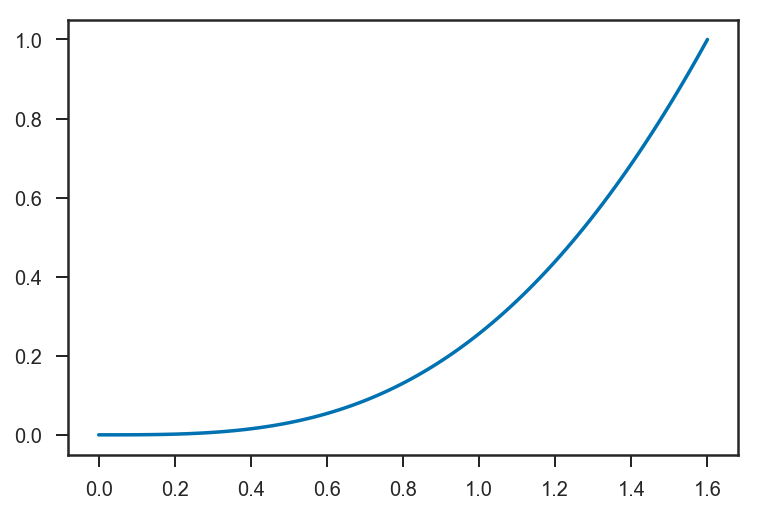

In [6]:
zs = linspace(0, 1.6, 100)
dNdz = 4.0*pi*100.0*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**2
N = trapz(dNdz, zs)

print('{:g} mergers per year out to redshift {:.2f}'.format(N, np.max(zs)))

dNdz /= trapz(dNdz, zs)

zcum = si.cumtrapz(dNdz, zs, initial=0)
plot(zs, zcum)

zinterp = interp1d(zcum, zs)

We will generate one year of mergers at design sensitivity (out to redshift 1.6, which is the detection horizon for our most massive black holes).  The mass distribution will be
$$
p\left( m_1, m_2 \right) \propto \frac{m_1^{-1.5}}{m_1 - M_\mathrm{min}}
$$
(flat in log $m_1$ and flat in $q$) and the rate will be 
$$
\frac{\mathrm{d} N}{\mathrm{d} V_C \mathrm{d} t} = 100 \, \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1} \left( 1 + z \right)^3
$$
in the comoving frame, or an observed merger density of 
$$
\frac{\mathrm{d} N}{\mathrm{d} z} = 100 \, \mathrm{Gpc}^{-3} \frac{\mathrm{d} V_C}{\mathrm{d} z} \left( 1 + z \right)^2.
$$

Let's talk a bit about the observational model.  We imagine that the true amplitude of the source in our detector (we will use only one detector here---with a hack that gives uncertainty appropriate to multiple detectors) is given by 
$$
A_\mathrm{true} = A_\mathrm{opt}\left( m_1, m_2, d_L \right) \Theta_\mathrm{true},
$$
where $A_\mathrm{opt}$ is the amplitude for a face-on, overhead source with the given parameters, and $\Theta_\mathrm{true}$ is drawn from the isotropic distribution of angular amplitude factors given, e.g., in [Finn & Chernoff (1993)](https://ui.adsabs.harvard.edu/#abs/1993PhRvD..47.2198F/abstract).  We imagine that we measure the amplitude with unit uncertainty:
$$
A_\mathrm{obs} = A_\mathrm{true} + N(0,1),
$$
and we also measure the angular factor
$$
\Theta_\mathrm{obs} = \Theta_\mathrm{true} + N\left(0, \sigma_\Theta\right)
$$
with 
$$
\sigma_\Theta = 0.15 \times \frac{8}{A_\mathrm{true}}.
$$
This value of $\sigma_\Theta$ is chosen to match the uncertainty of a median angular source at threshold to the relative distance uncertainty of GW170814.  Note that the observation of the angular factor is not restricted to the range $[0,1]$.  Only events with $A_\mathrm{obs} > 8$ are considered "detected."

We also observe a chirp mass: 
$$
\log \mathcal{M}_\mathrm{obs} = \log \left( \left( 1+z \right) \mathcal{M}_\mathrm{true}\left( m_1, m_2 \right) \right) + N\left( 0, \sigma_\mathrm{M}\right)
$$
and symmetric mass ratio
$$
\eta_\mathrm{obs} = \eta_\mathrm{true} \left( m_1, m_2 \right) + N\left( 0, \sigma_\eta \right)
$$
with 
$$
\sigma_\mathrm{M} = \sigma_\eta = 0.017 \times \frac{8}{A_\mathrm{true}};
$$
this uncertainty is tuned to match LVT151012.

In [10]:
rstate = random.get_state()
random.seed(752812)

try:
    ngen1 = random.poisson(N)
    ngen4 = random.poisson(4*N) # ngen1 + ngen4 is five years' worth of observations
    N_1yr = -1
    
    duty_cycle = 0.5

    # MMax and alpha numbers come from MAP on Fishbach & Holz (2017)
    MMin = 5
    MMax = 37.5
    alpha = 0.75
    beta = 0.0

    m1s = []
    m2s = []
    zs = []
    dls = []
    thetas = []

    mc_obs = []
    eta_obs = []
    A_obs = []
    theta_obs = []
    
    sigma_mc = []
    sigma_eta = []
    sigma_theta = []
    
    ts = concatenate(([0.0], sort(vt.thetas), [1.0]))
    
    tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

    for i in tnrange(ngen1+ngen4):
        if i == ngen1:
            # One year of events has elapsed
            N_1yr = len(m1s)
            
        if rand() > duty_cycle:
            continue # Skip it!
            
        m1 = ((MMax**(1-alpha)-MMin**(1-alpha))*rand() + MMin**(1-alpha))**(1.0/(1-alpha))
        m2 = ((m1**(1+beta)-MMin**(1+beta))*rand() + MMin**(1+beta))**(1.0/(1+beta))
        z = zinterp(rand())
        dl = Planck15.luminosity_distance(z).to(u.Gpc).value

        opt_snr = vt.optimal_snr(m1, m2, z, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)
        
        th = tcum(rand())
        
        A = th * opt_snr
        
        sa = 1.0
        st = 0.15*8.0/A
        
        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:        
            m1s.append(m1)
            m2s.append(m2)
            zs.append(z)
            dls.append(dl)
            thetas.append(th)
            
            th_obs = th + st*randn()

            mc, eta = mc_eta_from_m1_m2(m1, m2)

            sm = 8/Aobs*0.017
            se = 8/Aobs*0.017

            mco = random.lognormal(mean=log(mc*(1+z)), sigma=sm)
            etao = eta + se*randn() # This can give eta > 0.25 or eta < 0, but truncating causes numerical prob's in Stan, apparently

            mc_obs.append(mco)
            eta_obs.append(etao)
            A_obs.append(Aobs)
            theta_obs.append(th_obs)
            
            sigma_mc.append(sm)
            sigma_eta.append(se)
            sigma_theta.append(st)
finally:
    random.set_state(rstate)
    
with h5py.File('observations.h5', 'w') as out:
    out.attrs['N_1yr'] = N_1yr
    out.attrs['duty_cycle'] = duty_cycle
    
    out.attrs['alpha_true'] = alpha
    out.attrs['beta_true'] = beta
    out.attrs['MMin_true'] = MMin
    out.attrs['MMax_true'] = MMax
    
    tg = out.create_group('truth')
    for n, d in (('m1', m1s), ('m2', m2s), ('z', zs), ('dl', dls), ('theta', thetas)):
        tg.create_dataset(n, data=array(d), compression='gzip', shuffle=True)
    
    og = out.create_group('observations')
    for n, d in (('mc', mc_obs), ('eta', eta_obs), ('A', A_obs), ('theta', theta_obs), ('sigma_mc', sigma_mc), ('sigma_eta', sigma_eta), ('sigma_theta', sigma_theta)):
        og.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Executing the code below will re-load the generated observations:

In [5]:
with h5py.File('observations.h5', 'r') as inp:
    N_1yr = inp.attrs['N_1yr']
    duty_cycle = inp.attrs['duty_cycle']
    
    alpha = inp.attrs['alpha_true']
    beta = inp.attrs['beta_true']
    MMin = inp.attrs['MMin_true']
    MMax = inp.attrs['MMax_true']
    
    m1s = array(inp['truth']['m1'])
    m2s = array(inp['truth']['m2'])
    zs = array(inp['truth']['z'])
    dls = array(inp['truth']['dl'])
    thetas = array(inp['truth']['theta'])
    
    mc_obs = array(inp['observations']['mc'])
    eta_obs = array(inp['observations']['eta'])
    A_obs = array(inp['observations']['A'])
    theta_obs = array(inp['observations']['theta'])
    sigma_mc = array(inp['observations']['sigma_mc'])
    sigma_eta = array(inp['observations']['sigma_eta'])
    sigma_theta = array(inp['observations']['sigma_theta'])

Can we see the right behaviour in the maximum (or minimum?) mass?  Below is plotted the observed $\mathcal{M}$ versus $\mathcal{M}^{5/6}/A \simeq d_L$ (with errobars) for the hypothetical catalog.  

If we know the exact observed masses and distances to all the events, what can we reconstruct about the Hubble constant?

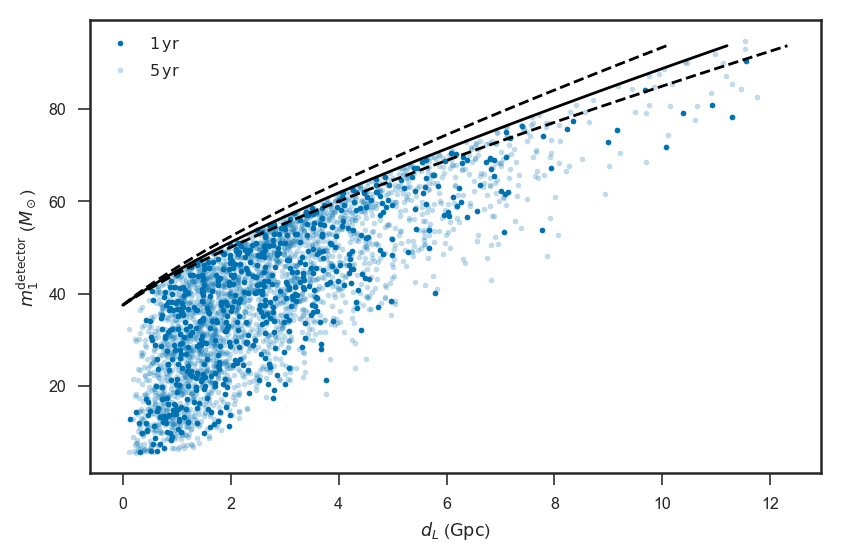

In [6]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):

    plot(dls[:N_1yr], (1+zs[:N_1yr])*m1s[:N_1yr], '.', label=r'$1\,\mathrm{yr}$')
    plot(dls, (1+zs)*m1s, '.', alpha=0.25, color=sns.color_palette()[0], label=r'$5\,\mathrm{yr}$')
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')

    z = linspace(0,1.5,100)
    d = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(d, (1+z)*MMax, '-k')
    plot(0.9*d, (1+z)*MMax, '--k')
    plot(1.1*d, (1+z)*MMax, '--k')

    legend(loc='best')

    tight_layout()
    savefig('paper/plots/m1-dL-true.pdf')
    
    with h5py.File('paper/plots/m1-dL-true.h5', 'w') as out:
        def cd(g,n,d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dls', dls[:N_1yr])
        cd(g1, 'zs', zs[:N_1yr])
        cd(g1, 'm1s', m1s[:N_1yr])
        
        g5 = out.create_group('5yr')
        cd(g5, 'dls', dls)
        cd(g5, 'zs', zs)
        cd(g5, 'm1s', m1s)
        
        c = out.create_group('cosmology')
        cd(c, 'dls', d)
        cd(c, 'MMax', (1+z)*MMax)
        cd(c, 'dls_0.9', 0.9*d)
        cd(c, 'dls_1.1', 1.1*d)

## Fitting With Perfect Mass and Distance Measurements

We will ignore issues of estimating the population for the moment, and just assume that it is uniform in $m_1$ and uniform in $z$, and fit for $M_\mathrm{max}$ and the cosmological parameters.  We used a reduced cosmological parameter space, with $H_0$, $\Omega_M$, and $w$ free; in particular, we assume a flat universe.

We perform four different fits:

* Everything free (with reasonable, but very broad priors).
* $\Omega_M$ and $w$ priors from Planck15 (Planck plus external observations constraints), fitting for $H_0$.
* $H_0$ prior at truth (here assumed Planck15) with 1% uncertainty (i.e. from BNS counterpart measurments in local universe), but $\Omega_M$ and $w$ free.
* $H_0$ with 1% and $\Omega_M$ from Planck15, but $w$ free.

In [7]:
mperfect = pystan.StanModel(file='PISNPerfectMass.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ae9b7d87d8cf27d1fd205e0f9874884 NOW.


Here are dicts implementing the four choices of prior:

In [8]:
data_free = {
    'mu_H0': 70.0,
    'sigma_H0': 20.0,
    'mu_Om': 0.3,
    'sigma_Om': 0.1,
    'mu_w': -1.0,
    'sigma_w': 0.5
}

data_Om_w_Planck = {
    'mu_H0': 70.0,
    'sigma_H0': 20.0,
    'mu_Om': 0.3089,
    'sigma_Om': 0.0062,
    'mu_w': -1.019,
    'sigma_w': 0.0775
}

H0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
data_H0_1pct = {
    'mu_H0': H0,
    'sigma_H0': 0.01*H0,
    'mu_Om': 0.3,
    'sigma_Om': 0.1,
    'mu_w': -1.0,
    'sigma_w': 0.5
}

data_H0_1pct_Om = {
    'mu_H0': H0,
    'sigma_H0': 0.01*H0,
    'mu_Om': 0.3089,
    'sigma_Om': 0.0062,
    'mu_w': -1.0,
    'sigma_w': 0.5
}

...and the common data for all the runs:

In [9]:
dperfect_full = {
    'nobs': len(m1s),
    'm1_obs': m1s*(1+zs),
    'dls': dls
}

Four fits:

In [14]:
d = dperfect_full.copy()
d.update(data_free)
fp_free = mperfect.sampling(data=d)

d = dperfect_full.copy()
d.update(data_Om_w_Planck)
fp_Om_w_Planck = mperfect.sampling(data=d)

d = dperfect_full.copy()
d.update(data_H0_1pct)
fp_H0_1pct = mperfect.sampling(data=d)

d = dperfect_full.copy()
d.update(data_H0_1pct_Om)
fp_H0_1pct_Om = mperfect.sampling(data=d)

And plot 'em, just to check for weirdness:

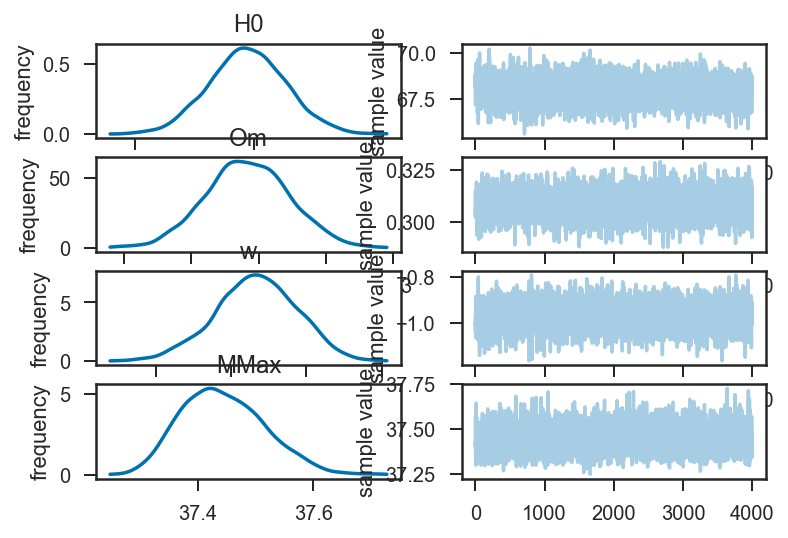

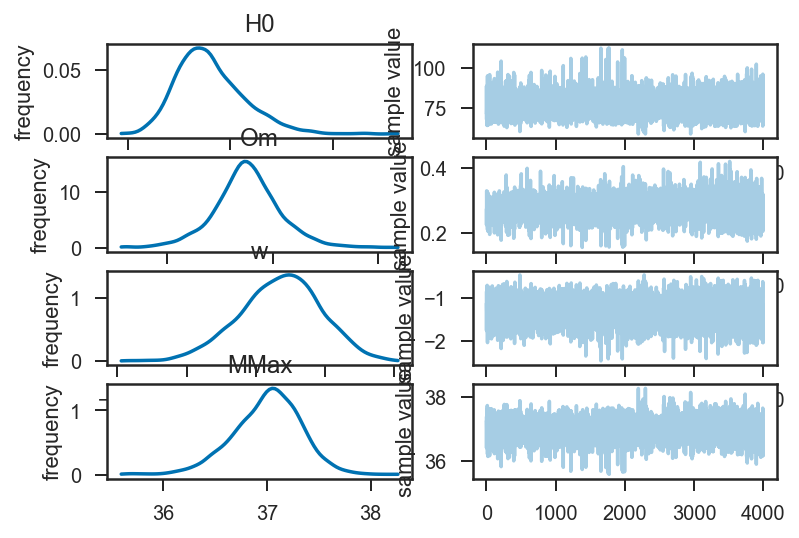

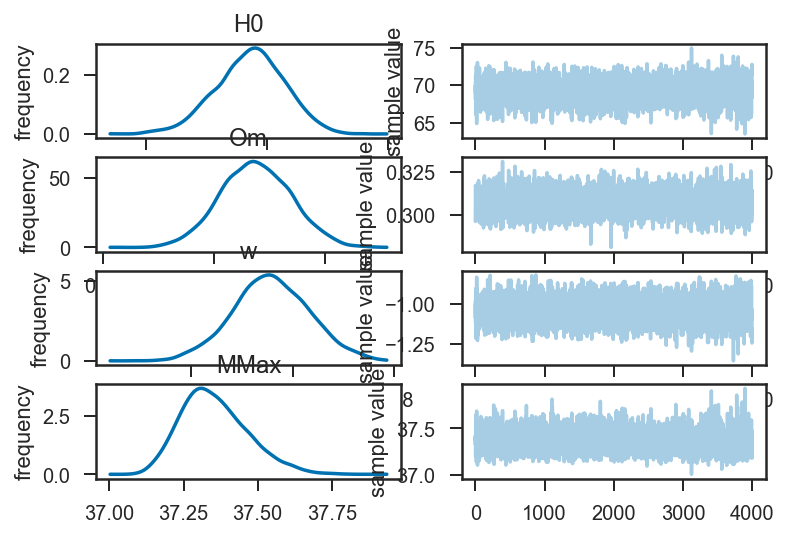

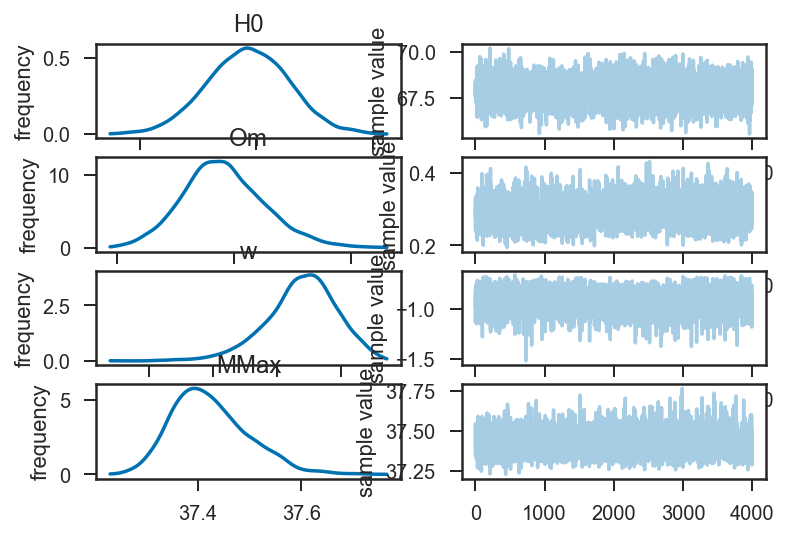

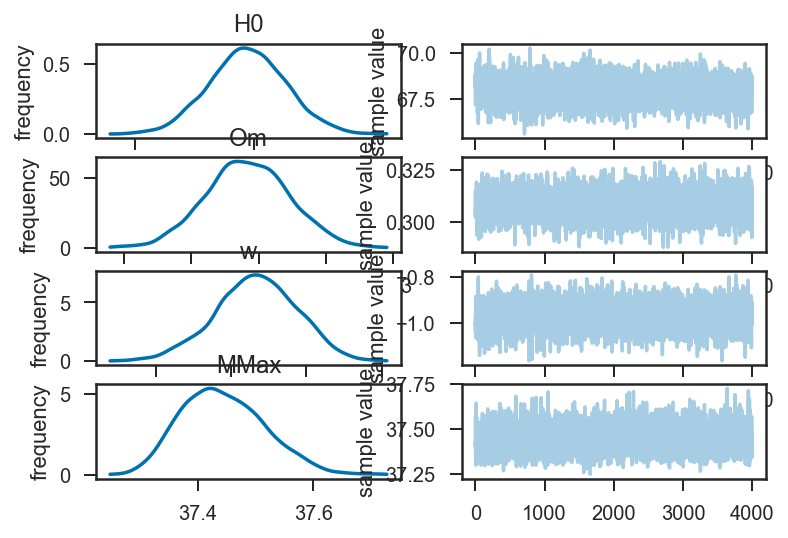

In [15]:
vnames = ['H0', 'Om', 'w', 'MMax']
fp_free.plot(vnames)
fp_Om_w_Planck.plot(vnames)
fp_H0_1pct.plot(vnames)
fp_H0_1pct_Om.plot(vnames)

Extract the chains:

In [17]:
cp_free = fp_free.extract(permuted=True)
cp_Om_w_Planck = fp_Om_w_Planck.extract(permuted=True)
cp_H0_1pct = fp_H0_1pct.extract(permuted=True)
cp_H0_1pct_Om = fp_H0_1pct_Om.extract(permuted=True)

Save the chains:

In [18]:
def save_perfect_chain(fname, chain):
    with h5py.File(fname, 'w') as out:
        for k in ['H0', 'Om', 'w', 'MMax', 'zs', 'm1s']:
            out.create_dataset(k, data=chain[k], compression='gzip', shuffle=True)
save_perfect_chain('perfect-free.h5', cp_free)
save_perfect_chain('perfect-Om_w_Planck.h5', cp_Om_w_Planck)
save_perfect_chain('perfect-H0_1pct.h5', cp_H0_1pct)
save_perfect_chain('perfect-H0_1pct_Om.h5', cp_H0_1pct_Om)

Here is a plot of the inferred source-frame masses for the all-variables-free model:

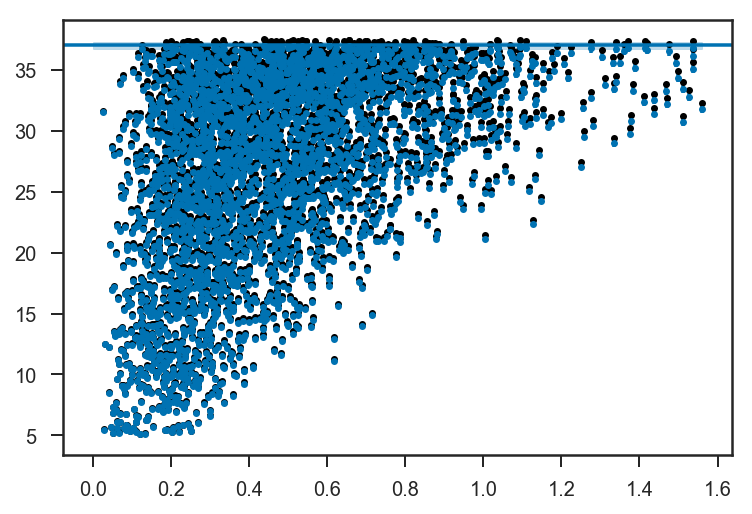

In [20]:
plot(zs, m1s, '.k')

mest = cp_free['m1s']

errorbar(zs, np.mean(mest, axis=0), yerr=np.std(mest, axis=0), fmt='.')

axhline(median(cp_free['MMax']))
fill_between([0, np.max(zs)], percentile(cp_free['MMax'], 84), percentile(cp_free['MMax'], 16), color=sns.color_palette()[0], alpha=0.25)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


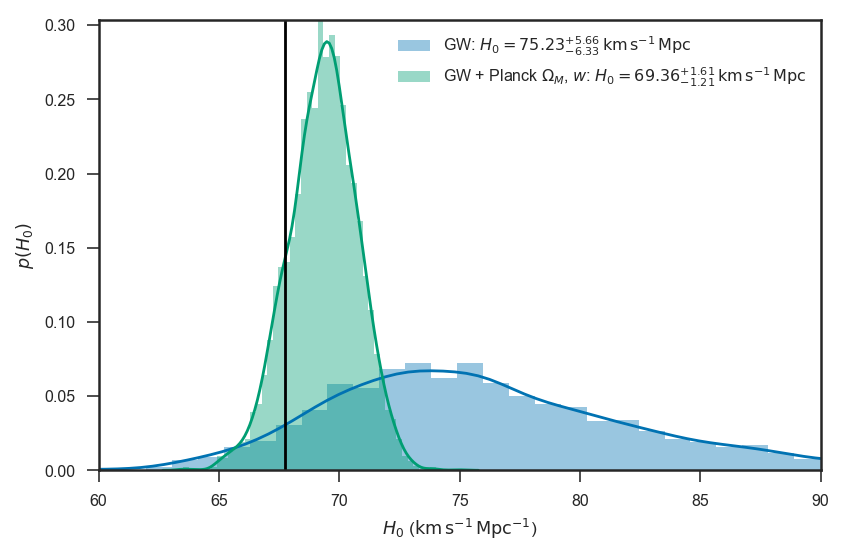

In [28]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    Hs_free = cp_free['H0']
    m = median(Hs_free)
    l, h = spd_interval(Hs_free, 0.68)
    sns.distplot(Hs_free, label=r'GW: $H_0 = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}$'.format(m, h-m, m-l))
    
    Hs_planck = cp_Om_w_Planck['H0']
    m = median(Hs_planck)
    l, h = spd_interval(Hs_planck, 0.68)
    sns.distplot(Hs_planck, label=r'GW + Planck $\Omega_M$, $w$: $H_0 = {:.2f}^{{+{:.2f}}}_{{-{:.2f}}} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}$'.format(m, h-m, m-l))

    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H_0 \right)$')
    legend(loc='best')
    axis(xmin=60,xmax=90)
    tight_layout()
    savefig('paper/plots/H0-exact.pdf')
    
    with h5py.File('paper/plots/H0-exact.h5', 'w') as out:
        f = out.create_group('GW')
        f.create_dataset('H0', data=Hs_free, shuffle=True, compression='gzip')
        
        f = out.create_group('GW+Planck')
        f.create_dataset('H0', data=Hs_planck, shuffle=True, compression='gzip')        

In [32]:
def cor(c):
    corner.corner(column_stack([c[k] for k in ['H0', 'Om', 'w']]),
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)',
                      r'$\Omega_M$',
                      r'$w$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value,
                      Planck15.Om0,
                      -1],
              show_titles=True,
              quantiles=[0.16, 0.84])

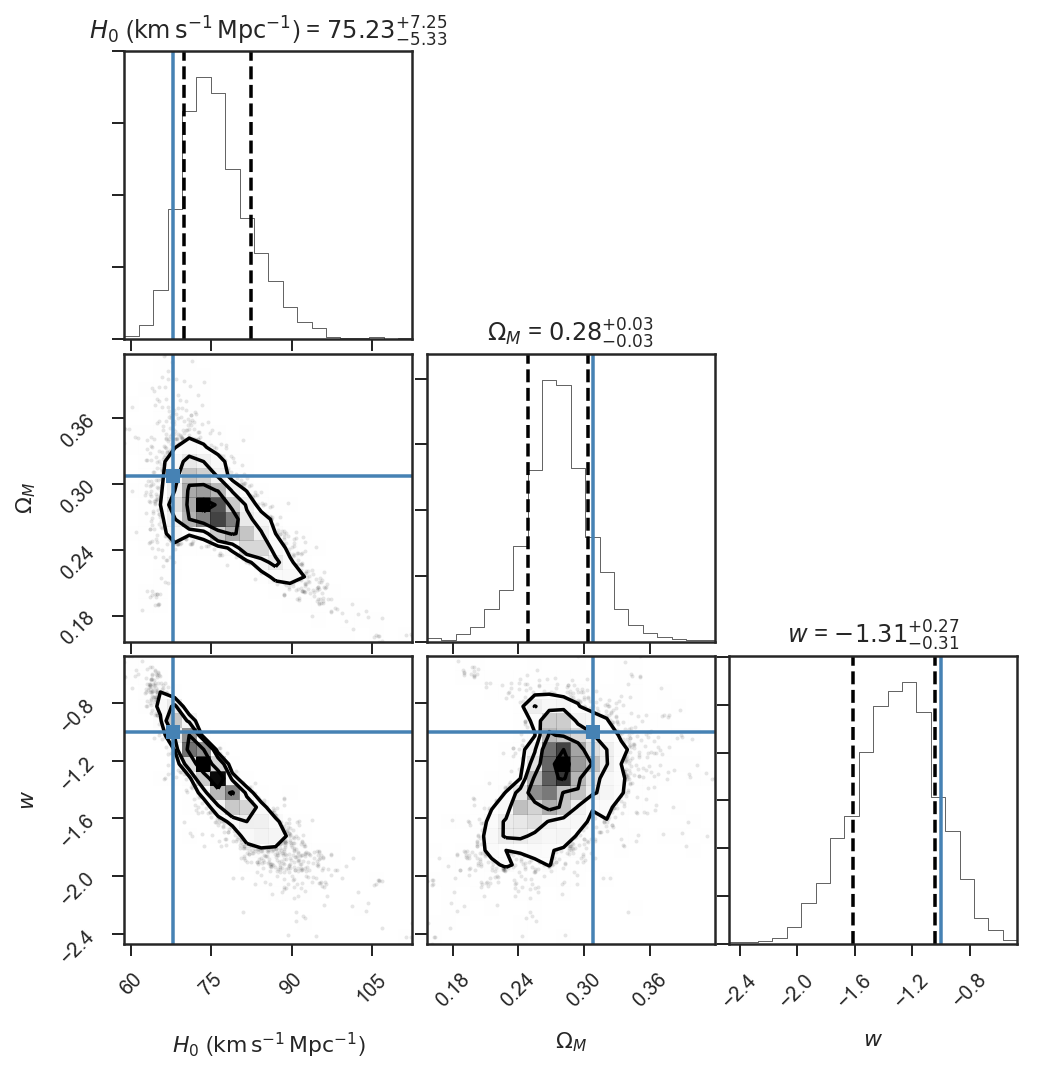

In [33]:
cor(cp_free)

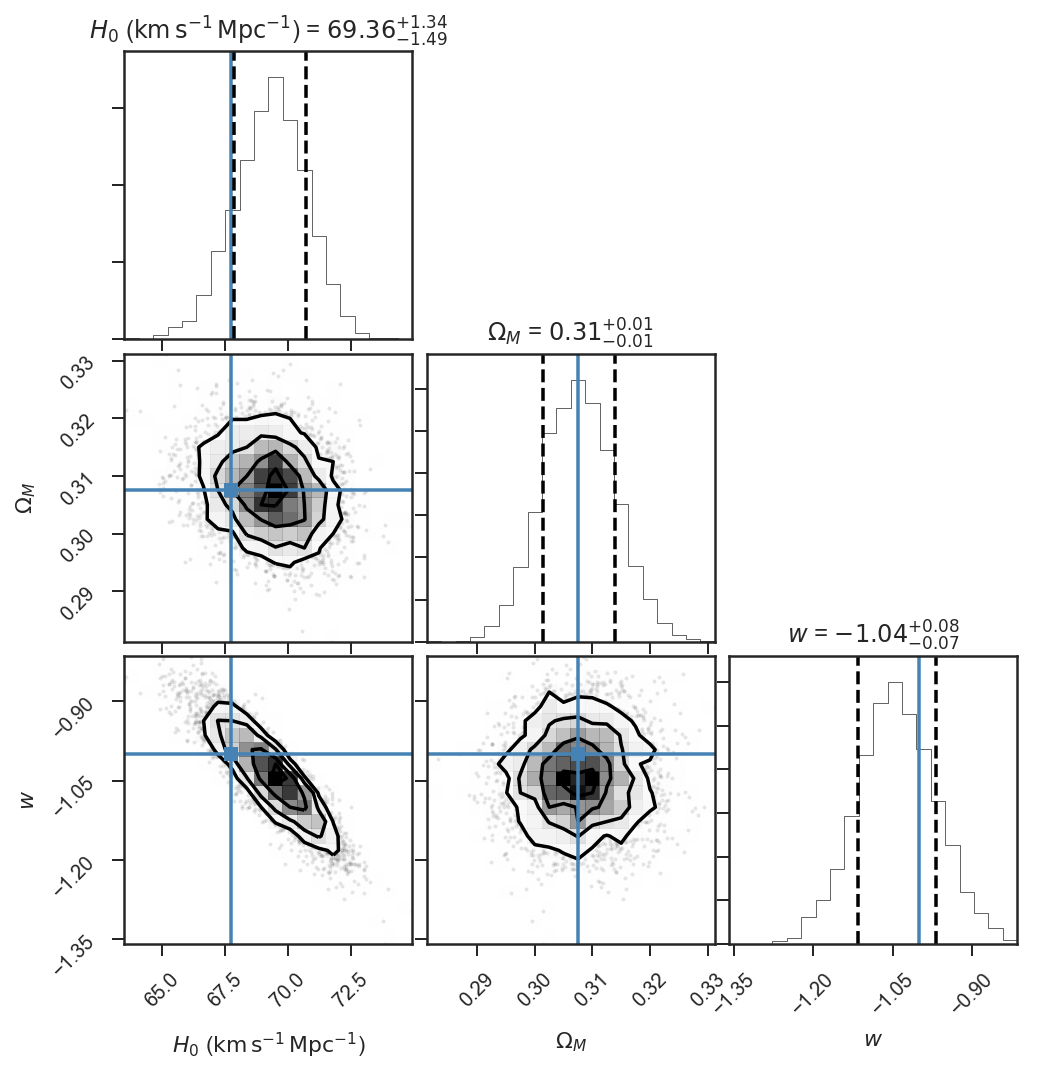

In [34]:
cor(cp_Om_w_Planck)

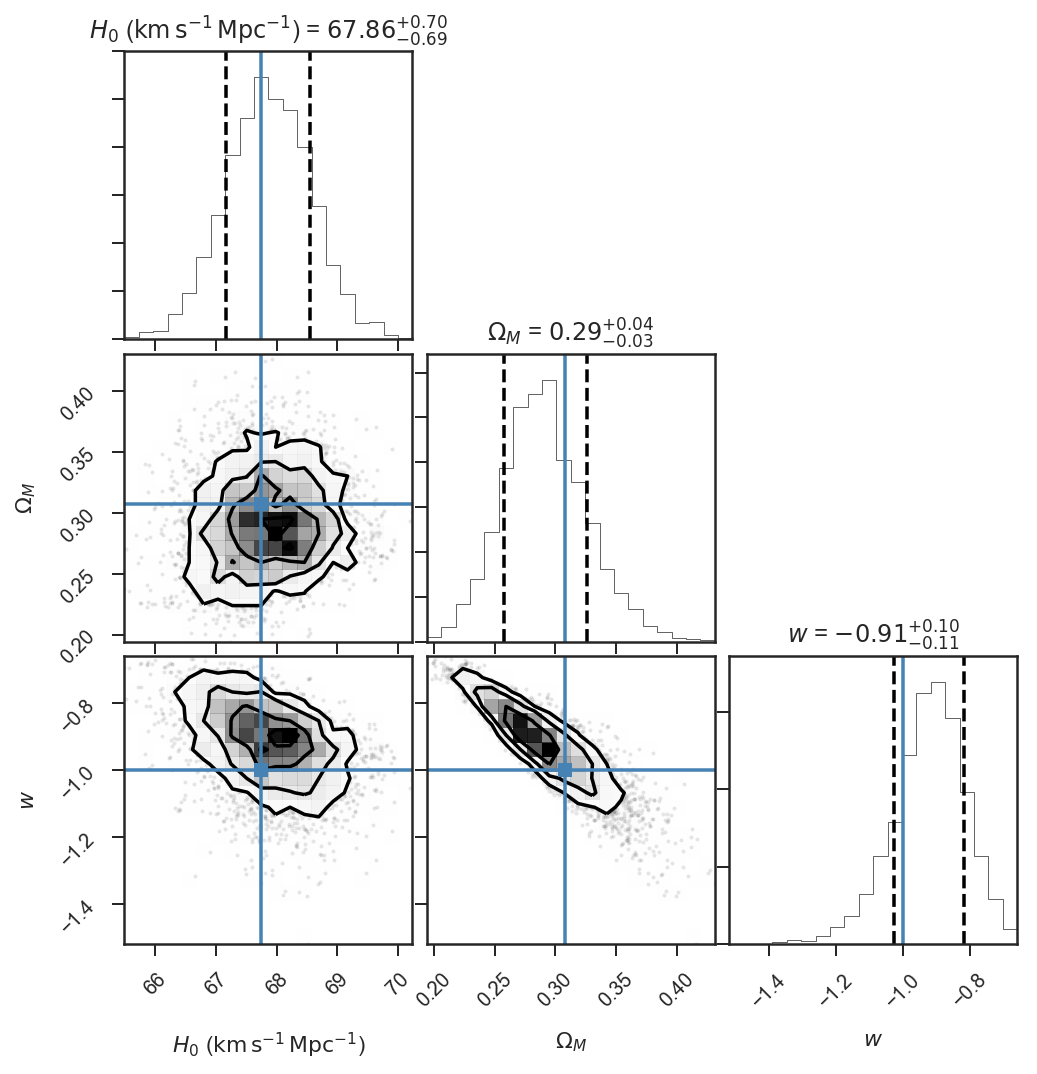

In [35]:
cor(cp_H0_1pct)

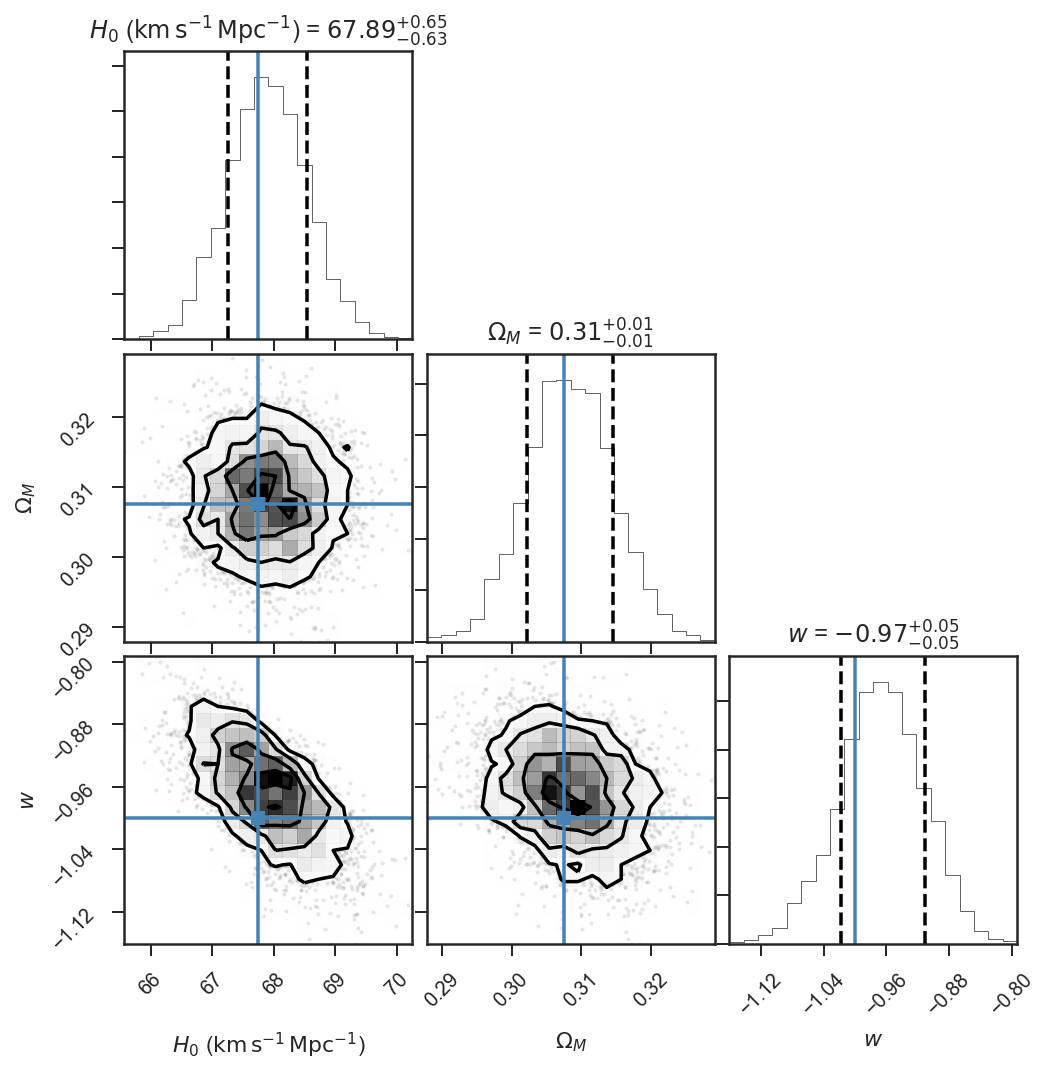

In [36]:
cor(cp_H0_1pct_Om)

*If* we get an independent 1% measurement on $H_0$, then we can measure $w$ to better accuracy than the existing Planck results (not sure if it's best yet, but it may be close):

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


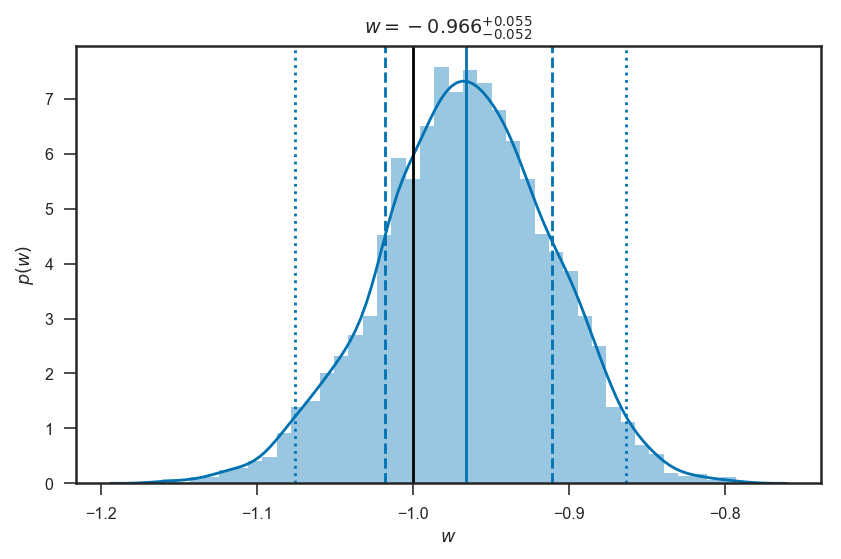

In [42]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    m = median(cp_H0_1pct_Om['w'])
    l, h = spd_interval(cp_H0_1pct_Om['w'], 0.68)
    ll, hh = spd_interval(cp_H0_1pct_Om['w'], 0.95)

    sns.distplot(cp_H0_1pct_Om['w'])
    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

    axvline(-1, color='k')

    title(r'$w = {:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(m, h-m, m-l))
    xlabel(r'$w$')
    ylabel(r'$p(w)$')
    
    tight_layout()
    savefig('paper/plots/w-exact.pdf')
    
with h5py.File('paper/plots/w-exact.h5', 'w') as out:
    out.create_dataset('w', data=cp_H0_1pct['w'], compression='gzip', shuffle=True)

Another way to view this is to plot $H(z)$:

In [45]:
def Hz(z, H0, Om, w):
    return H0*np.sqrt(Om*(1+z)**3 + (1.0-Om)*(1+z)**(3*(1+w)))

Text(0,0.5,'$H(z)$ ($\\mathrm{km} \\, \\mathrm{s}^{-1} \\, \\mathrm{Mpc}^{-1}$)')

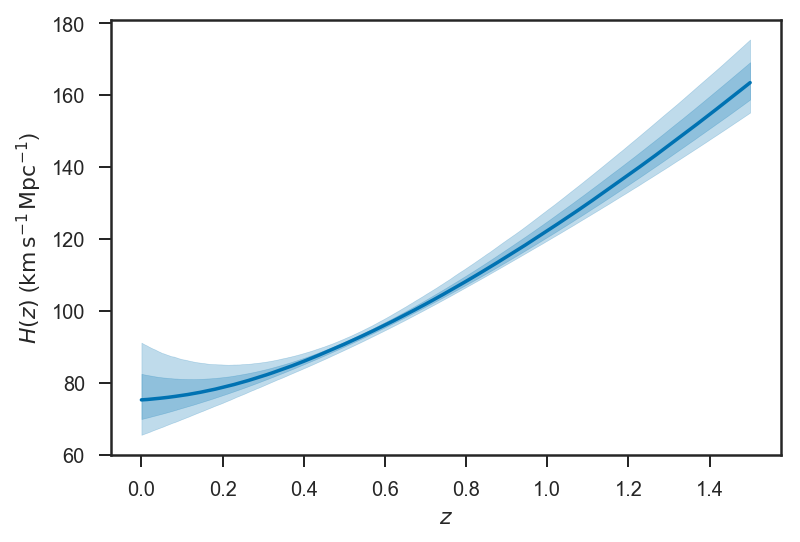

In [46]:
zs = linspace(0, 1.5, 1000)
Hzs = Hz(zs[newaxis,:], cp_free['H0'][:,newaxis], cp_free['Om'][:, newaxis], cp_free['w'][:, newaxis])
plot(zs, median(Hzs, axis=0))
fill_between(zs, percentile(Hzs, 84, axis=0), percentile(Hzs, 16, axis=0), alpha=0.25, color=sns.color_palette()[0])
fill_between(zs, percentile(Hzs, 97.5, axis=0), percentile(Hzs, 2.5, axis=0), alpha=0.25, color=sns.color_palette()[0])

xlabel(r'$z$')
ylabel(r'$H(z)$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')

...and I think we see the reason for the negative correlation between $H_0$ and $w$: the fulcrum redshift (is that the term?) is $z \simeq 0.6$.  If $H_0$ rises more curvature (i.e. acceleration) is required to hit the spot at the fulcrum.

## Accounting For Observational Uncertainty

### Generate Mock PE Samples

Now we begin to account for observational uncertainty.  We will first produce posteriors (with flat priors, so proportional to the likelihoods) on $m_1^\mathrm{obs}$, $m_2^\mathrm{obs}$, and $d_L$; these will approximate the actual PE posteriors one would obtain from analysis of LIGO's data.  Then, posterior (likelihood) samples in hand, we will proceed to compute the population parameters.

In [47]:
model = pystan.StanModel(file='PISNLineParameters.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4093c61ab66f228faa53d5c09e9d0e15 NOW.


For this model, we will need to have the optimal SNR at $d_L = 1 \, \mathrm{Gpc}$ in a grid; the cell below takes a long time to run, but saves its results to disk.  Executing the next cell will re-load the stored data.

In [ ]:
ms = logspace(log10(1), log10(200), 100)
def osnr(m1m2):
    m1, m2 = m1m2
    z = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)
    
    # m1, m2 are the *observed* masses, so we need to un-redshift them:
    return vt.optimal_snr(m1/(1+z), m2/(1+z), z, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)

M1S, M2S = meshgrid(ms, ms, indexing='ij')

OSNRS = []
for m1,m2 in tqdm_notebook(zip(M1S.ravel(), M2S.ravel())):
    OSNRS.append(osnr((m1,m2)))
OSNRS = array(OSNRS).reshape(M1S.shape)

with h5py.File('optimal_snr.h5', 'w') as out:
    out.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
    out.create_dataset('SNR', data=OSNRS, compression='gzip', shuffle=True)

Run this cell to re-load the optimal SNR grid.

In [7]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    OSNRS = array(inp['SNR'])
M1S, M2S = meshgrid(ms, ms, indexing='ij')

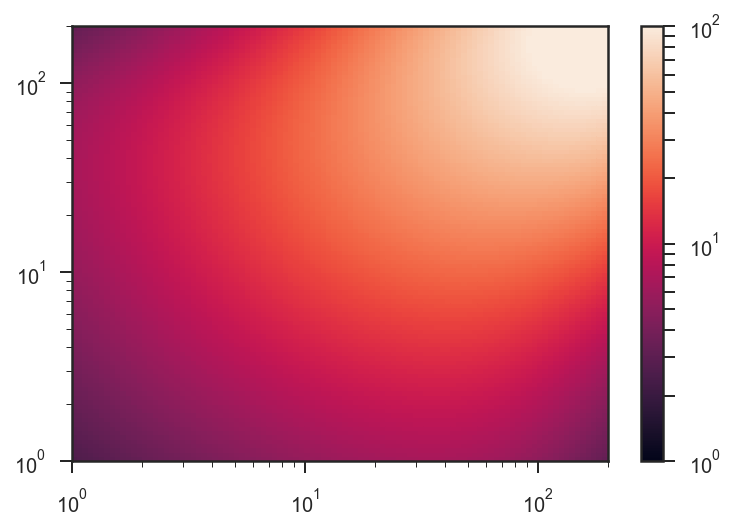

In [6]:
pcolormesh(M1S, M2S, OSNRS, norm=LogNorm(), vmin=1, vmax=100)
colorbar()
xscale('log')
yscale('log')

In [8]:
dl_max = Planck15.luminosity_distance(2.0).to(u.Gpc).value

We are going to impose a prior on theta that is simple and approximately represents the distribution of thetas.  We choose a Gaussian with moments matched to the actual theta distribution:

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


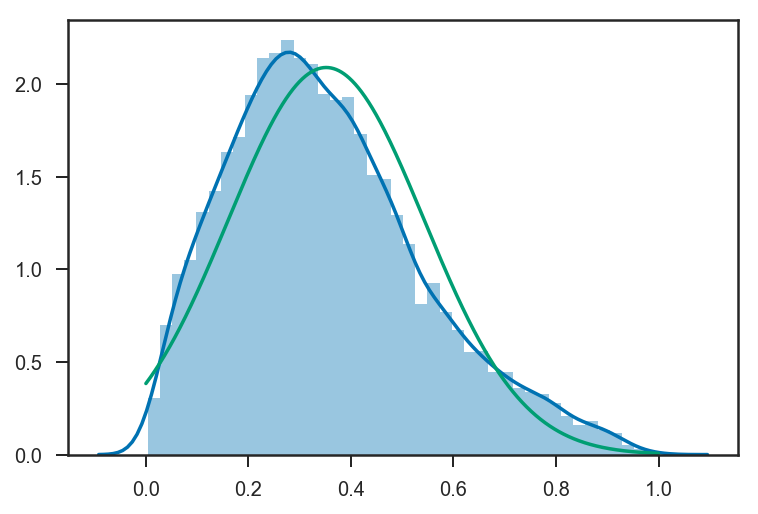

In [8]:
sns.distplot(vt.thetas)

mu = mean(vt.thetas)
sig = std(vt.thetas)

xs = linspace(0, 1, 1000)
plot(xs, ss.norm(loc=mu, scale=sig).pdf(xs))

In [37]:
chain = {'m1s': zeros((0, 4000)),
         'm2s': zeros((0, 4000)),
         'mcs': zeros((0, 4000)),
         'etas': zeros((0, 4000)),
         'qs': zeros((0, 4000)),
         'dLs': zeros((0, 4000)),
         'opt_snrs': zeros((0, 4000)),
         'thetas': zeros((0,4000))}

mut = np.mean(vt.thetas)
sigt = np.std(vt.thetas)

for i in tnrange(len(m1s)):
    d = {
        'mc_obs': mc_obs[i],
        'eta_obs': eta_obs[i],
        'A_obs': A_obs[i],
        'theta_obs': theta_obs[i],
        
        'sigma_mc': sigma_mc[i],
        'sigma_eta': sigma_eta[i],
        'sigma_theta': sigma_theta[i],
        
        'nm': len(ms),
        'ms': ms,
        'opt_snrs': OSNRS,
        
        'dL_max': dl_max,
        'mu_theta': mut,
        'sig_theta': sigt
    }
    init = {
        'm1': m1s[i],
        'm2': m2s[i],
        'dL': dls[i],
        'theta': thetas[i]
    }
    iter = 2000
    thin = 1
    while True:
        f = model.sampling(data=d, iter=iter, thin=thin, init=(init,)*4)
        
        # Iterate with more samples if Rhat > 1.1 for any parameter.
        if np.any(f.summary()['summary'][:,-1] > 1.1):
            iter *= 2
            thin *= 2
            warnings.warn('re-doing sampling with more iterations: {:d}'.format(iter))
        else:
            break
    c = f.extract(permuted=True)
    
    for n in ['m1', 'm2', 'mc', 'eta', 'dL', 'opt_snr', 'theta']:
        ns = n + 's'
        chain[ns] = row_stack((chain[ns], c[n]))

with h5py.File('parameters.h5', 'w') as out:
    out.attrs['Tobs'] = 5*duty_cycle
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n], compression='gzip', shuffle=True)
with h5py.File('parameters_1yr.h5', 'w') as out:
    out.attrs['Tobs'] = 1*duty_cycle
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n][:N_1yr,:], compression='gzip', shuffle=True)
with h5py.File('parameters_small.h5', 'w') as out:
    out.attrs['Tobs'] = 0.1*duty_cycle
    N_0p1yr = int(round(N_1yr/10.0))
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n][:N_0p1yr,:], compression='gzip', shuffle=True)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing samplin

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iteration

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000


In [48]:
chain = {}
with h5py.File('parameters.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain[n] = array(inp[n])
chain_1yr = {}
with h5py.File('parameters_1yr.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain_1yr[n] = array(inp[n])
chain_small = {}
with h5py.File('parameters_small.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain_small[n] = array(inp[n])

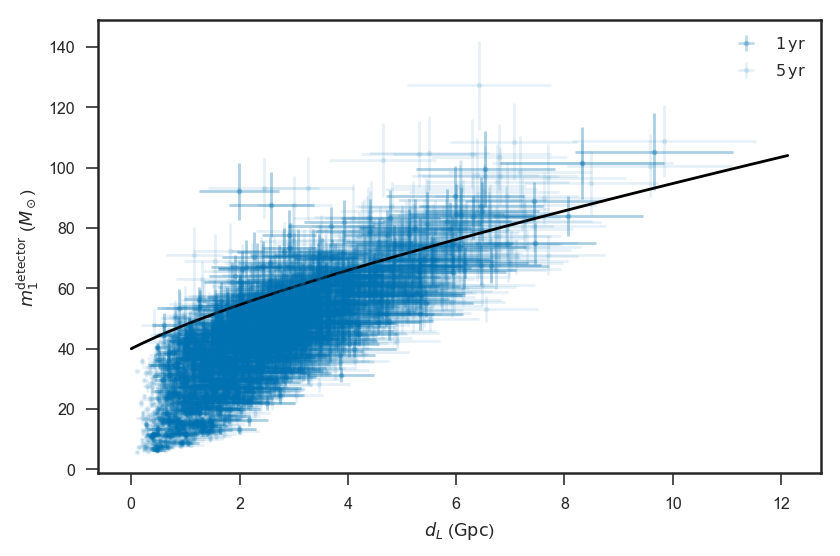

In [6]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    m1o = chain_1yr['m1s']
    dlo = chain_1yr['dLs']

    m1a = chain['m1s']
    dla = chain['dLs']

    errorbar(np.mean(dlo, axis=1), np.mean(m1o, axis=1), xerr=std(dlo, axis=1), yerr=std(m1o, axis=1), fmt='.', label=r'$1 \, \mathrm{yr}$', alpha=0.25)
    errorbar(np.mean(dla, axis=1), np.mean(m1a, axis=1), xerr=std(dla, axis=1), yerr=std(m1a, axis=1), fmt='.', color=sns.color_palette()[0], alpha=0.1, label=r'$5 \, \mathrm{yr}$')

    z = linspace(0, 1.6, 100)
    dl = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(dl, 40*(1+z), '-k')

    legend(loc='best')
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')
    
    tight_layout()
    savefig('paper/plots/m1-dL-obs.pdf')
    
    with h5py.File('paper/plots/m1-dL-obs.h5', 'w') as out:
        def cd(g, n, d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dl_mean', mean(dlo, axis=1))
        cd(g1, 'dl_std', std(dlo, axis=1))
        cd(g1, 'm1_mean', mean(m1o, axis=1))
        cd(g1, 'm1_std', std(m1o, axis=1))
        
        g5 = out.create_group('5yr')
        cd(g5, 'dl_mean', mean(dla, axis=1))
        cd(g5, 'dl_std', std(dla, axis=1))
        cd(g5, 'm1_mean', mean(m1a, axis=1))
        cd(g5, 'm1_std', std(m1a, axis=1))
        
        c = out.create_group('cosmology')
        cd(c, 'dls', dl)
        cd(c, 'MMax', 40*(1+z))

Let's just check the uncertainty that is produced in our simulations.  For GW170814, we have 

* $m_1 = 30.5^{+5.7}_{-3.0} \, M_\odot$
* $d_L = 540^{+130}_{-210} \, \mathrm{Mpc}$

both at 90% CL.  That corresponds to a range in $\log m_1$ of $\Delta_{90} \log m_1 = 0.27$ and a range of $d_L$ of $\Delta_{90} d_L = 0.71$.  How does this compare to a typical and marginal detected event from our sample?

In [11]:
delta90_logm1 = log(percentile(chain['m1s'], 95, axis=1))-log(percentile(chain['m1s'], 5, axis=1))
delta90_logdl = log(percentile(chain['dLs'], 95, axis=1))-log(percentile(chain['dLs'], 5, axis=1))

In [12]:
print('median d90(log(m1)) = {:.2f}'.format(median(delta90_logm1)))
print('95th percentile d90(log(m1)) = {:.2f}'.format(percentile(delta90_logm1, 95)))

median d90(log(m1)) = 0.31
95th percentile d90(log(m1)) = 0.43


In [13]:
print('median d90(log(dl)) = {:.2f}'.format(median(delta90_logdl)))
print('95th percentile d90(log(dl)) = {:.2f}'.format(percentile(delta90_logdl, 95)))

median d90(log(dl)) = 0.58
95th percentile d90(log(dl)) = 1.03


It is fun to look at some of the inferences; execute the cell below to view a random event in $m_1$-$m_2$-$d_L$ space.  You can also change the number of samples used to construct the density.

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color',

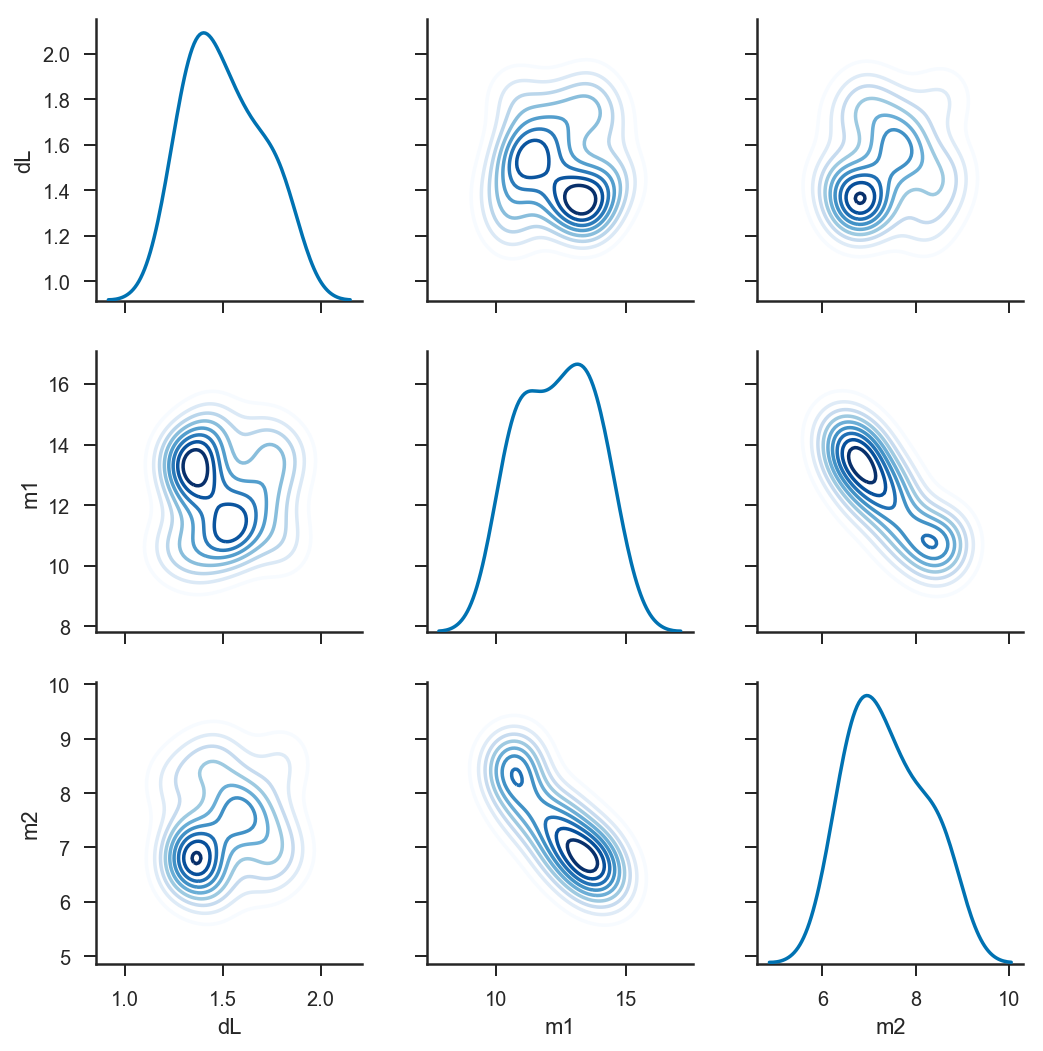

In [16]:
i = randint(chain['m1s'].shape[0])
n = 16
s = random.choice(chain['m1s'].shape[1], replace=False, size=n)

df = pandas.DataFrame({'m1': chain['m1s'][i,s],
                       'm2': chain['m2s'][i,s],
                       'dL': chain['dLs'][i,s]})

g = sns.PairGrid(df, diag_sharey=False)
g.map_offdiag(sns.kdeplot, cmap='Blues')
g.map_diag(sns.kdeplot)

### Generate A Selected Population

From the errorbar population plot above, it is clear that we will need to model the population in order to get the most from this data set; simply doing a linear regression is likely to be biased because the population prior is *not* flat in $m_1$, $q$, and $d_L$.  If we are going to model the population, selection effects will become important, so let's produce a sample of selected systems drawn flat in $m_1^\mathrm{obs}$, $q$, and $d_L$ so we can Monte-Carlo the selection integral.  Based on experiments, we will want the variance in the selection function integral to be much smaller than the statistical variance of the measurement on $H_0$; this will require at least an order of magnitude more systems drawn for the selection function than actually observed, since these events get non-uniformly weighted.

We want to generate systems between the following masses and distances:

In [109]:
np.min(chain['m2s']), np.max(chain['m1s']), np.max(chain['dLs'])

(3.162933091146668, 176.90795315367188, 15.911095092262359)

We can run the below for a bit, and then extended the selected set of systems using the auxllary application `extend_selected.py` (e.g. on a cluster).

In [ ]:
N_selection = 16384

dLmax = 1.2*np.max(chain['dLs'])

MObsMin = 0.5*np.min(chain['m2s'])
MObsMax = 1.2*np.max(chain['m1s'])

m1s_det = []
m2s_det = []
dls_det = []
wts_det = []
N_gen = 0
N_det = 0

ts = concatenate(([0.0], sort(vt.thetas), [1.0]))

tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

oi = interp2d(M1S, M2S, OSNRS)

def wt_fn(m1obs, m2obs, dlobs):
    m1wt = 1.0/(m1obs*(log(MObsMax) - log(MObsMin)))
    m2wt = 1.0/(m1obs - MObsMin)
    
    dlwt = 3.0*dlobs**2/dLmax**3
    
    return m1wt*m2wt*dlwt

with tqdm_notebook(total=N_selection) as bar:
    while N_det < N_selection:
        N_gen += 1
        m1obs = exp(random.uniform(low=log(MObsMin), high=log(MObsMax)))
        m2obs = random.uniform(low=MObsMin, high=m1obs)
                
        dl = dLmax*cbrt(rand())

        opt_snr = oi(m1obs, m2obs)/dl

        th = tcum(rand())

        A = th * opt_snr

        sa = 1.0
        st = 0.15*8.0/A

        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:     
            N_det += 1
            bar.update(1)
            
            m1s_det.append(m1obs)
            m2s_det.append(m2obs)
            dls_det.append(dl)
            wts_det.append(wt_fn(m1obs, m2obs, dl))

with h5py.File('selected.h5', 'w') as out:
    out.attrs['MObsMin'] = MObsMin
    out.attrs['MObsMax'] = MObsMax
    out.attrs['dLMax'] = dLmax
    out.attrs['NGen'] = N_gen
    
    for n, d in (('m1', m1s_det), ('m2', m2s_det), ('dl', dls_det), ('wt', wts_det)):
        out.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Executing the cell below will re-load the detected set of systems; we are going to go for overkill, and choose to have more than 400k detected systems (this is more than an order of magnitude larger than the number of systems we have in the 5-year data set).

In [49]:
with h5py.File('selected.h5', 'r') as inp:
    MObsMin = inp.attrs['MObsMin']
    MObsMax = inp.attrs['MObsMax']
    dLmax = inp.attrs['dLMax']
    N_gen = inp.attrs['NGen']
    
    m1s_det = array(inp['m1'])
    m2s_det = array(inp['m2'])
    dls_det = array(inp['dl'])
    wts_det = array(inp['wt'])

Here we check the variance in the $\left\langle N \right\rangle$ calculation for the true parameters given our data set of selected systems.

In [13]:
def Ez(z):
    Om = Planck15.Om0
    return sqrt(Om*(1+z)**3 + (1-Om))

def dzddL(dl, z, dH):
    return 1.0/(dl/(1+z) + (1+z)*dH/Ez(z))

def dNdm1dm2ddLdt(m1, m2, dl, z, R0, MMin, MMax, alpha, beta, gamma, dH):
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (1+beta)/(m1**(1+beta) - MMin**(1+beta))
    
    dNdm1dm2dVdt = R0 * m1**(-alpha) * m2**(beta) * m1norm * m2norm * (1+z)**(gamma-1)
    
    dNdm1dm2dzdt = dNdm1dm2dVdt * 4.0*pi*(dl/(1+z))**2*dH/Ez(z)
    
    dNdm1dm2ddLdt = dNdm1dm2dzdt * dzddL(dl, z, dH)
    
    dNdm1dm2ddLdt[(m1>MMax) | (m2<MMin)] = 0
    
    return dNdm1dm2ddLdt

zinterp = linspace(0, 5, 1000)
dlinterp = Planck15.luminosity_distance(zinterp).to(u.Gpc).value

zs_det = interp1d(dlinterp, zinterp)(dls_det)
fs = dNdm1dm2ddLdt(m1s_det/(1+zs_det), m2s_det/(1+zs_det), dls_det, zs_det, 100.0, MMin, MMax, alpha, beta, 3.0, Planck15.hubble_distance.to(u.Gpc).value)
fs = fs / (1+zs_det)**2
fs = fs / wts_det

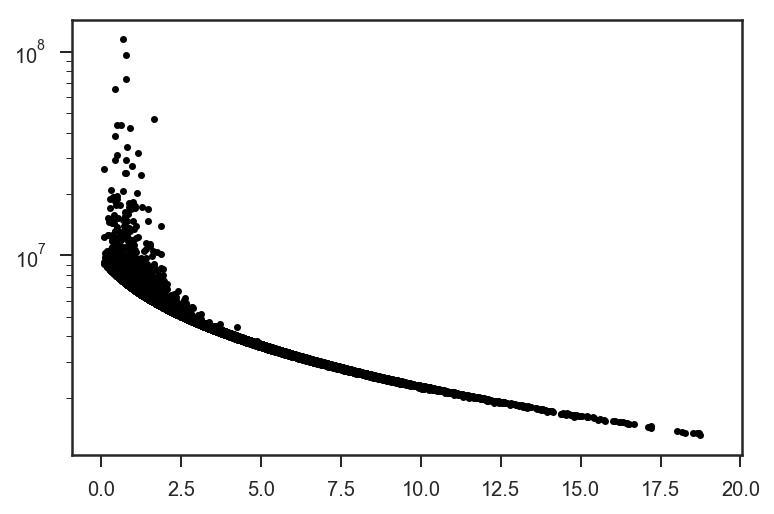

In [16]:
plot(dls_det, fs, '.k')
yscale('log')

Running the cell below gives the "effective number of samples," and the uncertainty on the selection integral.  The working hypothesis is that the uncertainty should be smaller than $\sqrt{N}$, the intrinsic uncertainty on the magnitude of the Poisson norm; alternately, the "effective number of samples" should be larger than the true number of samples.  To be safe, we ensure at least a factor of two between these numbers.  The result is:

* The "small" chain (1/10 of a year) needs at least ``2048`` samples.
* The 1 year chain needs at least ``32768`` samples.
* The 5 year chain needs at least ``131072`` samples.

This implies that we can use ~64 samples in the KDE before the KDE computation starts to dominate over the selection function computation, so that is what we will do (at least to start).

In [63]:
nd = 131072

s = np.random.choice(fs.shape[0], replace=False, size=nd)

Ng = int(round(N_gen*nd/float(fs.shape[0])))
mu = duty_cycle*np.sum(fs[s])/Ng
sigma = duty_cycle*np.sqrt(np.var(fs[s])*nd)/Ng

print('Nex = {:.2f} +/- {:.2f}, Neff = {:.1f}'.format(mu, sigma, mu*mu/(sigma*sigma)))

Nex = 641.86 +/- 7.11, Neff = 8145.2


Here is the spacing between detected samples as a function of mass; we use $m_1$ to determine the spacing at high mass and $m_2$ to determine the spacing at low mass.

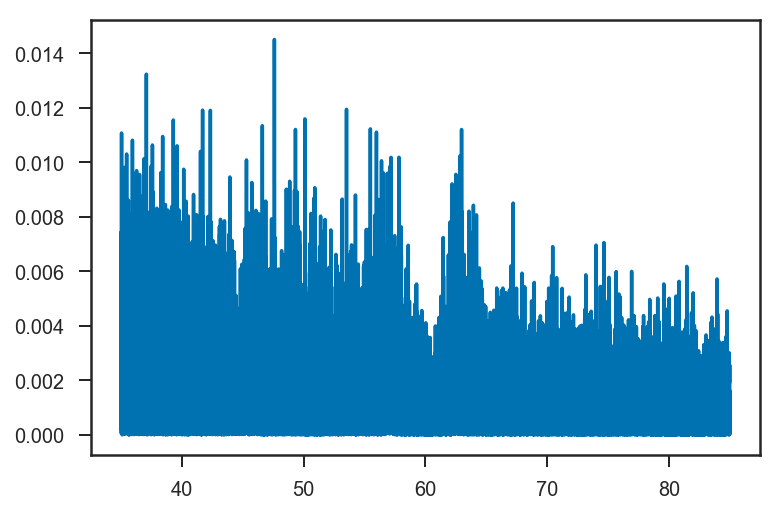

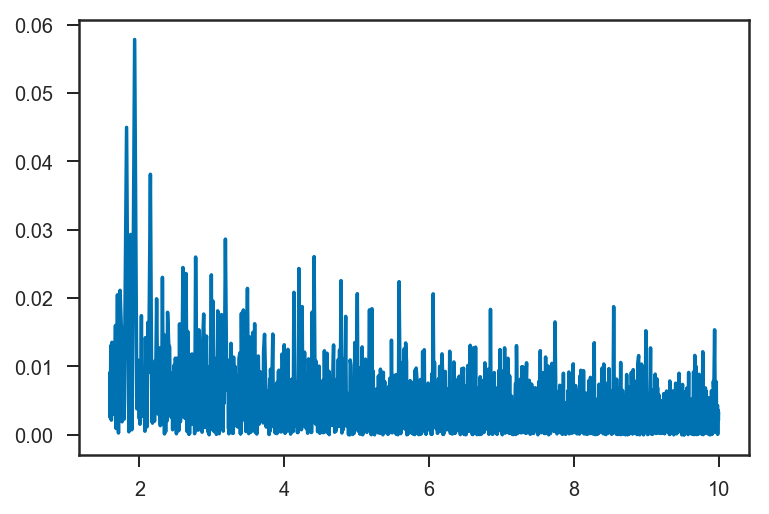

In [10]:
m = sort(m1s_det)
x = 0.5*(m[:-1]+m[1:])
y = diff(m)

figure()
s = (35 < x) & (x < 85)
plot(x[s],y[s])

m = sort(m2s_det)
x = 0.5*(m[:-1] + m[1:])
y = diff(m)

figure()
s = (1 < x) & (x < 10)
plot(x[s],y[s])

Let's see how many samples we will need to ensure that, at the true $H_0$, we have some sample below the true maximum mass.  From the below, we will see that there is at least one event that will not have *any* samples below the true maximum mass!

In [11]:
dlmax = max(np.max(chain['dLs']), np.max(dls_det))
dli = linspace(1e-3, 1.1*dlmax, 1000)
zi = array([cosmo.z_at_value(Planck15.luminosity_distance, d*u.Gpc) for d in dli])

z = interp1d(dli, zi)(chain['dLs'])

m1 = chain['m1s']/(1+z)

imax = np.argmax(np.min(m1, axis=1))
mmax_sample = np.min(m1, axis=1)[imax]

print('MMax from sampling at true H0 is {:.1f}'.format(mmax_sample))

MMax from sampling at true H0 is 41.0


So, we need to interpolate somehow on the likelihood, or we will have ruled out the true maximum mass.  The cell below gives the maximum values of the minimum mass samples over events and also the standard deviation of the Scott's rule KDE for that event.  For fewer than ~128 samples, the true minimum mass is more than 3-sigma away from the smallest mass sample (so the runs are likely to be biased to smaller values of $H_0$).  We can confirm this by comparing runs with different numbers of samples and checking when convergence is achieved.

In [12]:
n = 128
dli = linspace(0, max(np.max(chain['dLs']), np.max(dls_det)), 250)
zi = array([0.0] + [cosmo.z_at_value(Planck15.luminosity_distance, d*u.Gpc) for d in dli[1:]])

z = interp1d(dli, zi)(chain['dLs'][:,:n])
m1 = chain['m1s'][:,:n]/(1+z)

i = np.argmax(np.min(m1, axis=1))
mm = np.min(m1, axis=1)[i]
sm = np.std(m1, axis=1)[i]/n**(1.0/5.0)

mm, sm, MMax, (mm-MMax)/sm

(47.939410994682795, 3.7967128144444398, 37.5, 2.7495919509546467)

### Plot Results of Analysis

Here is where the rubber meets the road; the fitting is done in the ``fit.py`` script, which leaves an HDF5 file for the chains that can be re-loaded.

In [56]:
def load_chains(f):
    names = ['H0', 'Om', 'w', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma', 'm1_true', 'm2_true', 'dl_true', 'z_true', 'Nex', 'neff_det']
    
    c = {}
    with h5py.File(f, 'r') as inp:
        for n in names:
            c[n] = array(inp[n])
    return c

In [100]:
def traceplot(c):
    nr = 13
    nc = 1
    
    names = ['H0', 'Om', 'w', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma', 'm1_true', 'm2_true', 'dl_true', 'z_true']
    
    for i in range(nr):
        subplot(nr, nc, i+1)
        
        x = c[names[i]]
        
        if len(x.shape) == 1:
            plot(x)
        elif len(x.shape) == 2:
            for j in range(x.shape[1]):
                plot(x[:,j])
        else:
            raise NotImplementedError('Cannot plot matrices or higher-dimensional tensors')
        
        ylabel(names[i])
    tight_layout()

In [57]:
def Neff_plot(c, *args, **kwargs):
    sns.distplot(c['neff_det'], *args, **kwargs)
    
    ndet = c['m1_true'].shape[1]
    
    axvline(ndet, color='k')
    
    xlabel(r'$N_\mathrm{eff}$')
    ylabel(r'$p\left( N_\mathrm{eff} \right)$')

In [78]:
def cosmo_corner_plot(c, *args, **kwargs):
    corner.corner(column_stack([c[n] for n in ['H0', 'Om', 'w']]),
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$\Omega_M$',
                      r'$w$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      Planck15.Om0,
                      -1],
              truth_color=sns.color_palette()[0],
              quantiles=[0.16, 0.84],
              show_titles=True)

In [84]:
def pop_corner_plot(c, *args, **kwargs):
    corner.corner(column_stack([c[n] for n in ['R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma']]),
              labels=[r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[100.0,
                      MMin,
                      MMax,
                      alpha,
                      beta,
                      3],
              truth_color=sns.color_palette()[0],
              quantiles=[0.16, 0.84],
              show_titles=True)

In [89]:
def H0_plot(c, *args, **kwargs):
    sns.kdeplot(c['H0'], *args, **kwargs)
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H_0 \mid d \right)$')
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

    m = median(c['H0'])
    l, h = spd_interval(c['H0'], 0.68)
    ll, hh = spd_interval(c['H0'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [90]:
def w_plot(c, *args, **kwargs):
    sns.kdeplot(c['w'], *args, **kwargs)
    xlabel(r'$w$')
    ylabel(r'$p\left( w \right)$')
    axvline(-1)

    m = median(c['w'])
    l, h = spd_interval(c['w'], 0.68)
    ll, hh = spd_interval(c['w'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [91]:
def MMax_plot(c, *args, **kwargs):
    sns.kdeplot(c['MMax'], *args, **kwargs)
    xlabel(r'$M_\mathrm{max}$ ($M_\odot$)')
    ylabel(r'$p\left( M_\mathrm{max} \right)$')
    axvline(MMax, color='k')

    m = median(c['MMax'])
    l, h = spd_interval(c['MMax'], 0.68)
    ll, hh = spd_interval(c['MMax'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [92]:
def interval_string(c, k, prefix='', postfix='', f=0.68):
    s = c[k]
    m = median(s)
    l, h = spd_interval(s, f)
    
    dl = m-l
    dh = h-m
    
    il = 10**(int(np.ceil(log10(dl))) - 2)
    ih = 10**(int(np.ceil(log10(dl))) - 2)
    
    i = min(il, ih)
    
    m = i*int(round(m/i))
    dl = i*int(round(dl/i))
    dh = i*int(round(dh/i))
    
    return prefix + '{:g}^{{+{:g}}}_{{-{:g}}}'.format(m, dh, dl) + postfix

In [93]:
def mass_plot(c, *args, **kwargs):
    m1 = mean(c['m1_true'], axis=0)
    sm1 = std(c['m1_true'], axis=0)

    dl = mean(c['dl_true'], axis=0)
    sdl = std(c['dl_true'], axis=0)

    errorbar(dl, m1, xerr=sdl, yerr=sm1, fmt='.', *args, **kwargs)

    gca().set_xlim(left=0)
    gca().set_ylim(bottom=0)

    xl, xh = gca().get_xlim()

    plot([xl,xh], median(c['MMax'])*ones(2), color='k', ls='-')
    fill_between([xl,xh], percentile(c['MMax'], 84), percentile(c['MMax'], 16), alpha=0.25, color='k')
    fill_between([xl,xh], percentile(c['MMax'], 97.5), percentile(c['MMax'], 2.5), alpha=0.25, color='k')

    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1$ ($M_\odot$)')

In [98]:
def post_process(f):
    c = load_chains(f)
    
    traceplot(c)
    
    figure()    
    Neff_plot(c)
    
    cosmo_corner_plot(c)
    pop_corner_plot(c)
    
    figure()
    H0_plot(c)
    title(interval_string(c, 'H0', prefix=r'$H_0 = ', postfix=r' \, \mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$'))
    
    figure()
    w_plot(c)
    title(interval_string(c, 'w', prefix=r'$w = ', postfix='$'))
    
    figure()
    MMax_plot(c)
    title(interval_string(c, 'MMax', prefix=r'$M_\mathrm{max} = ', postfix=' \, M_\odot$'))
    
    figure()
    mass_plot(c)
    
    return c

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


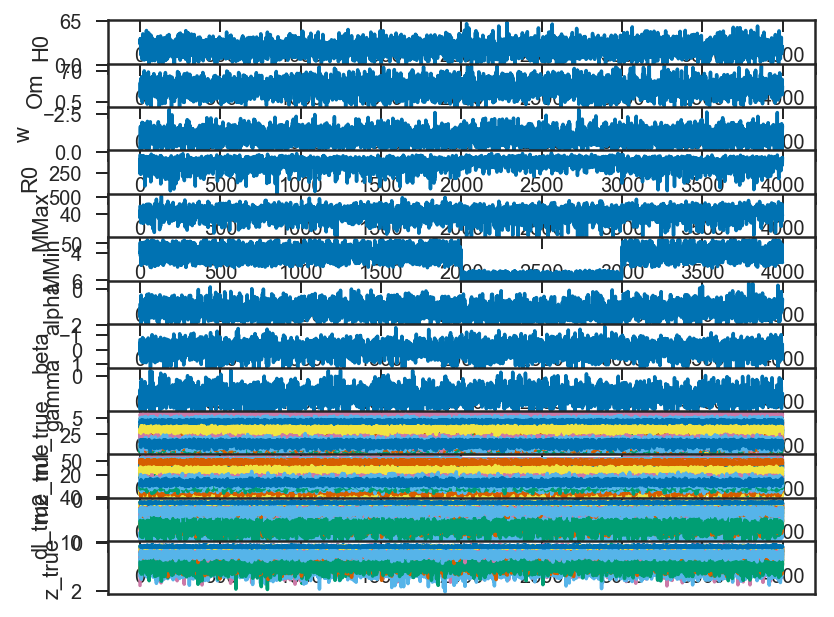

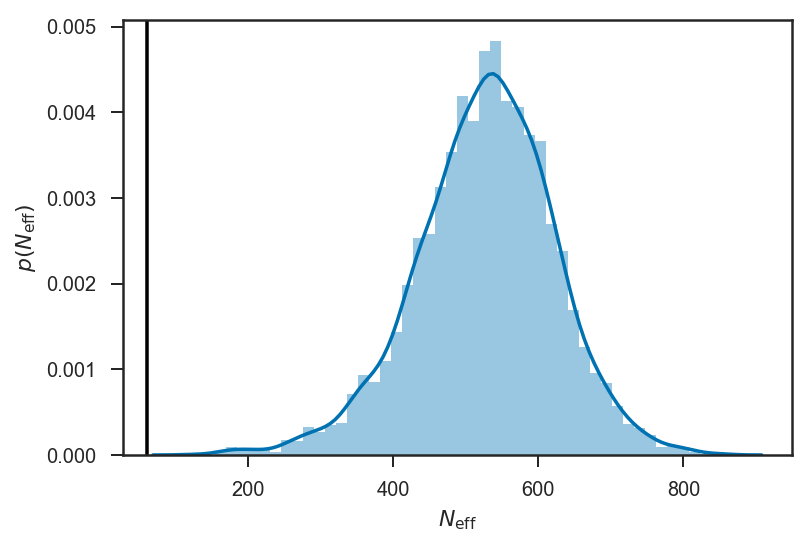

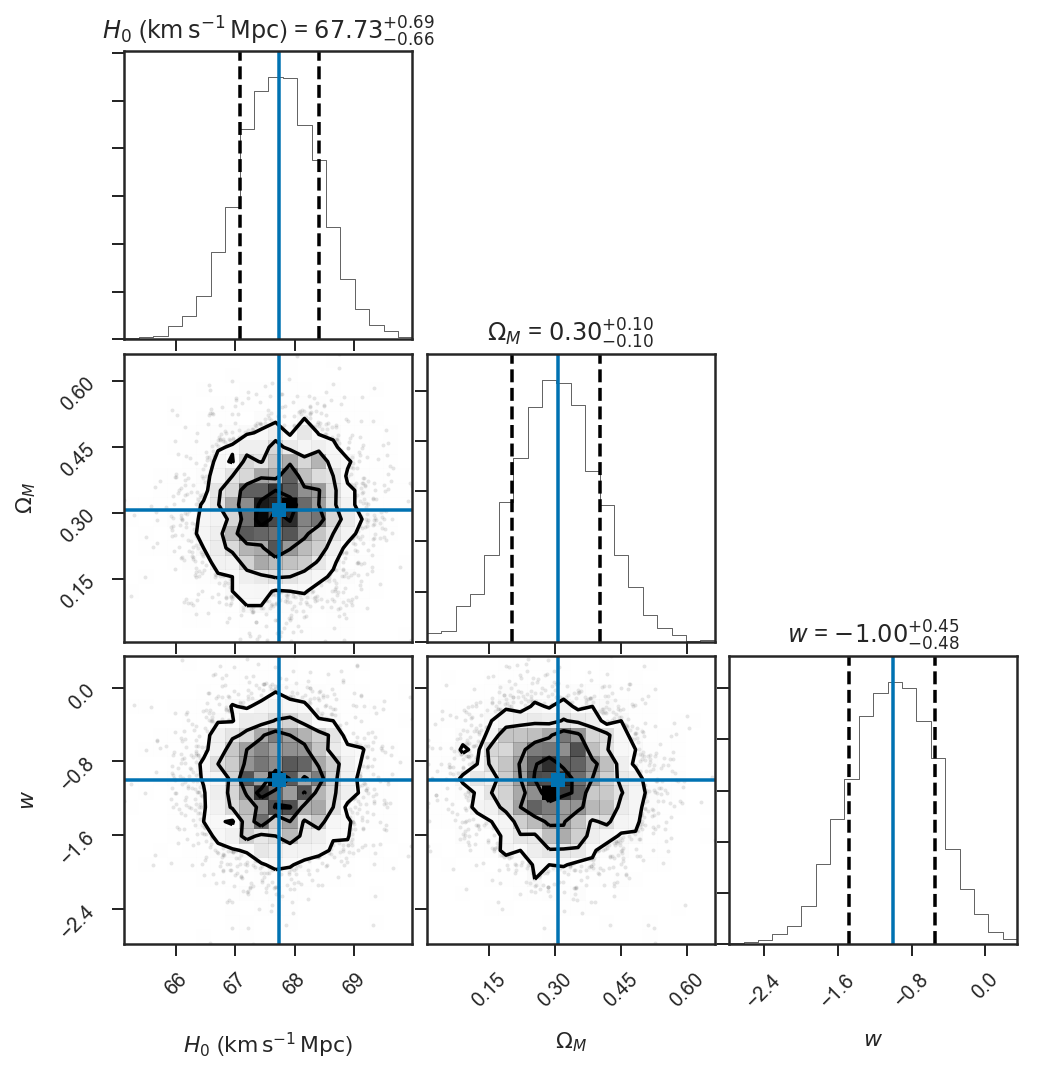

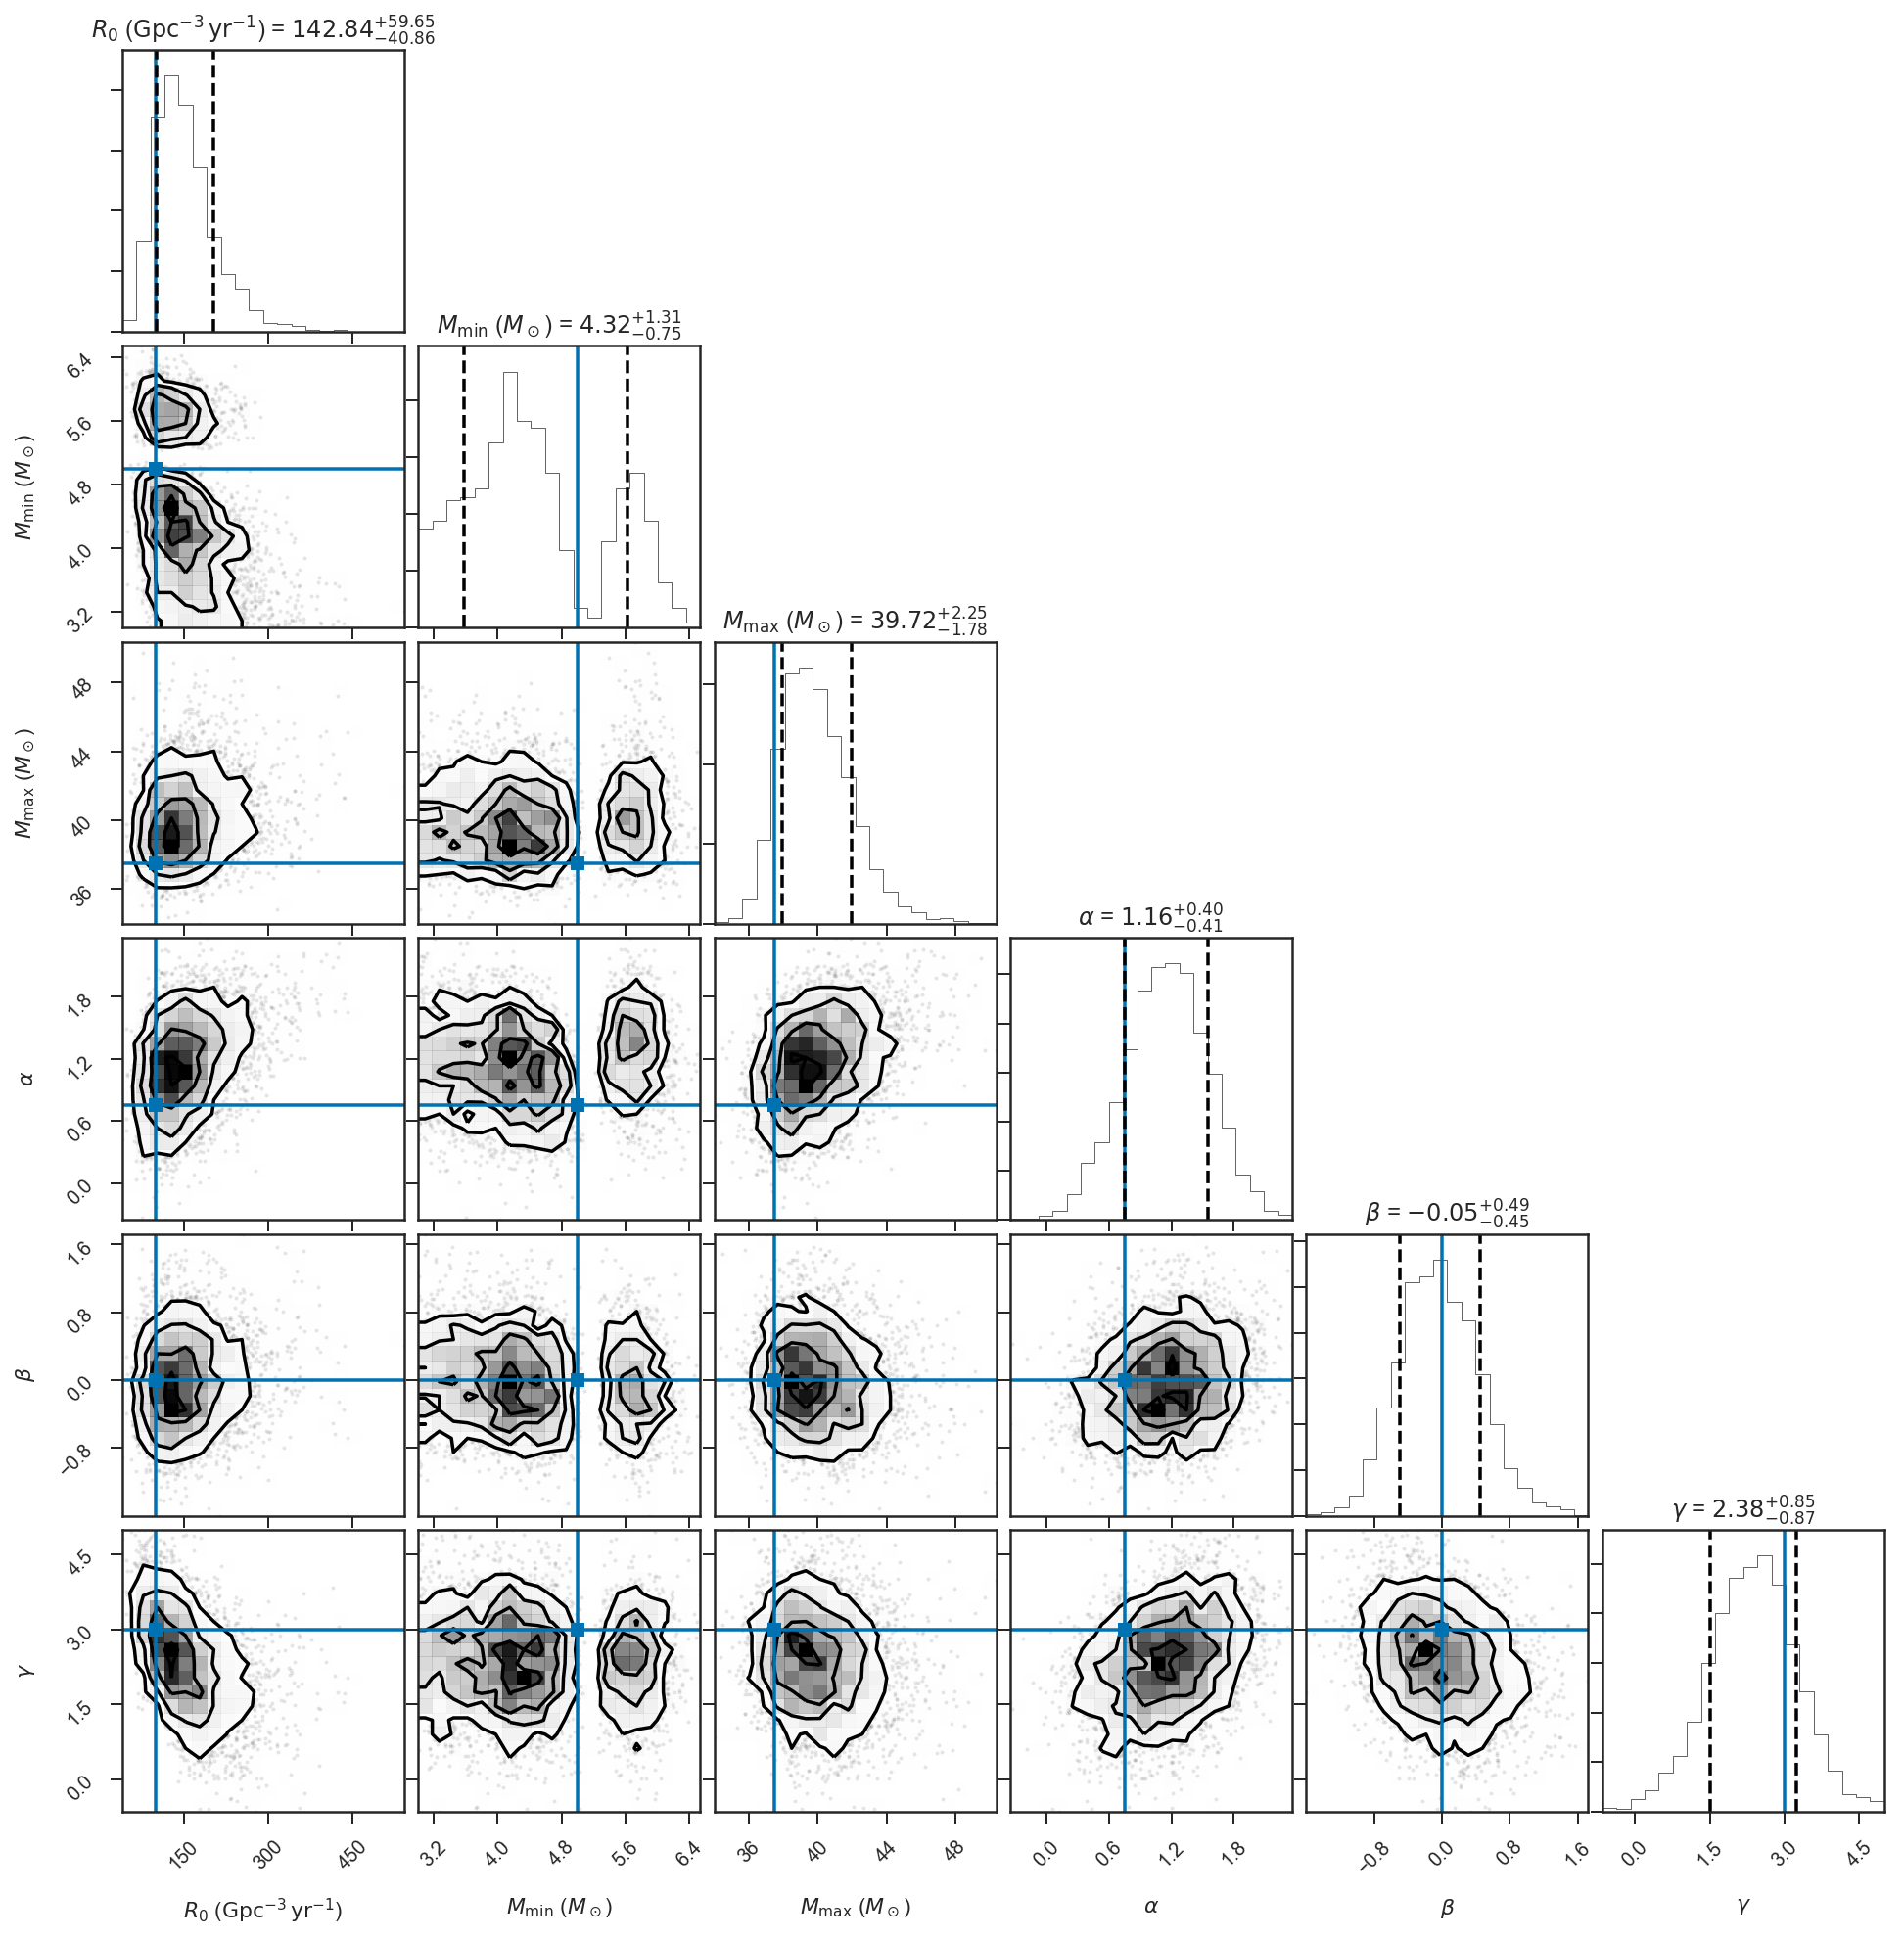

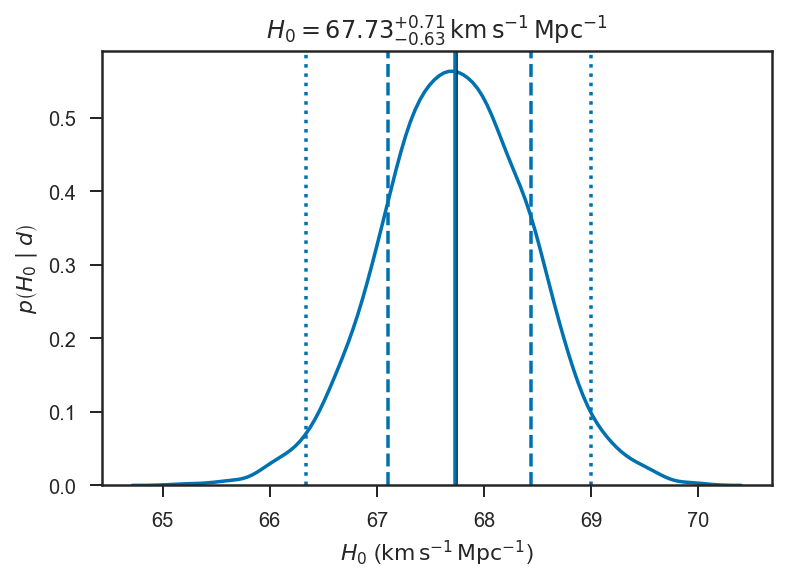

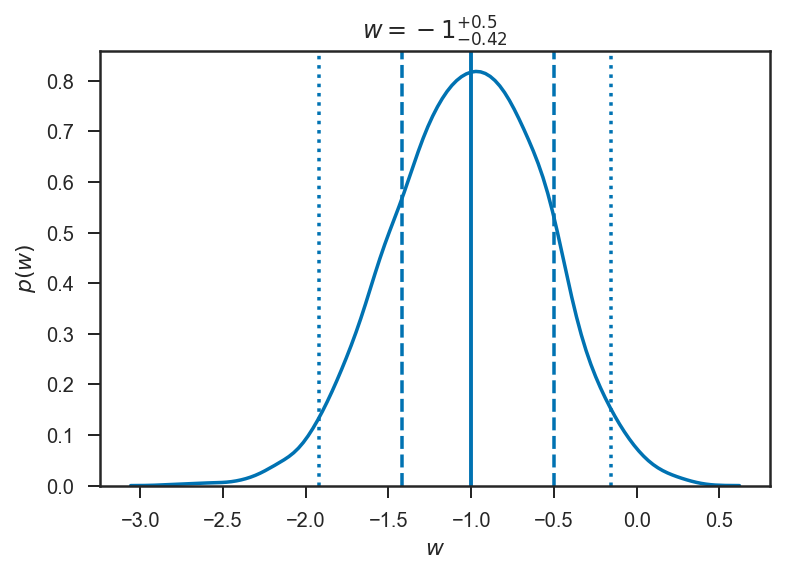

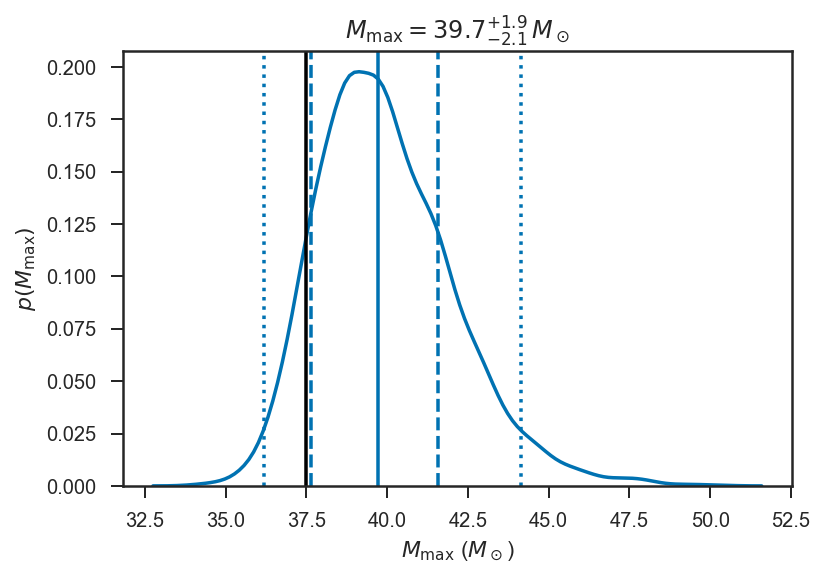

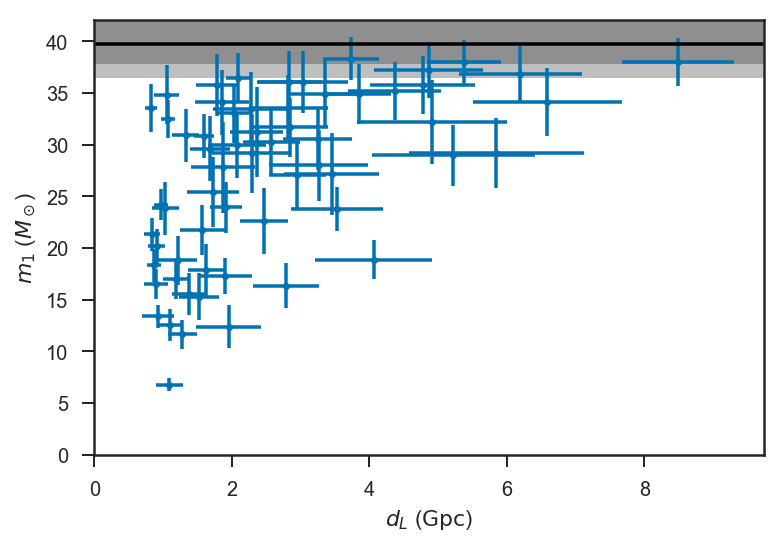

In [101]:
c = post_process('population_small_H0.h5')

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


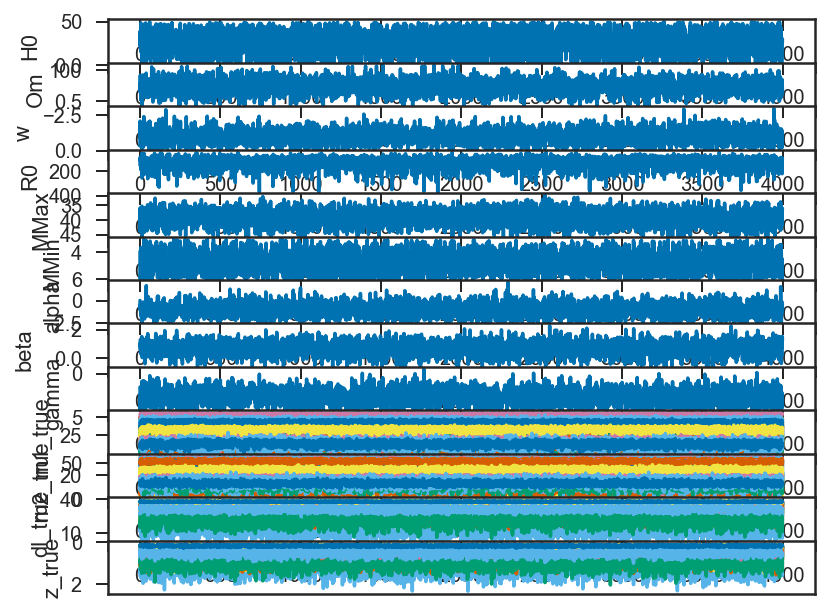

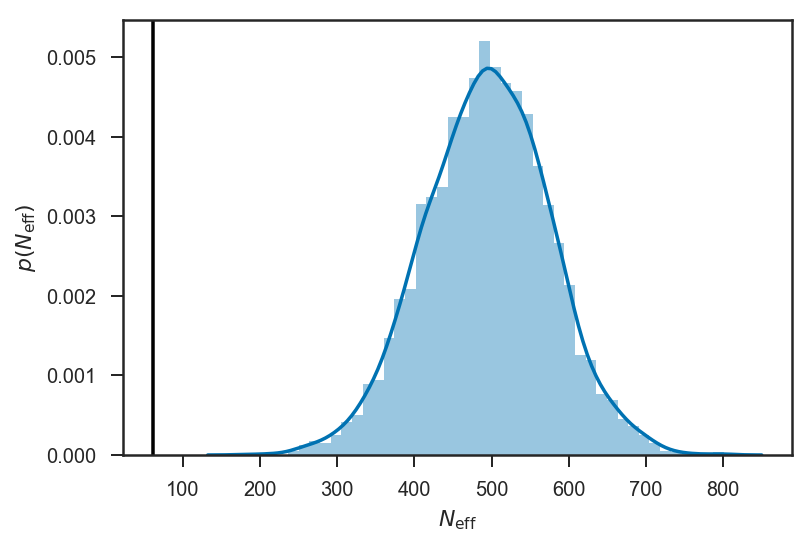

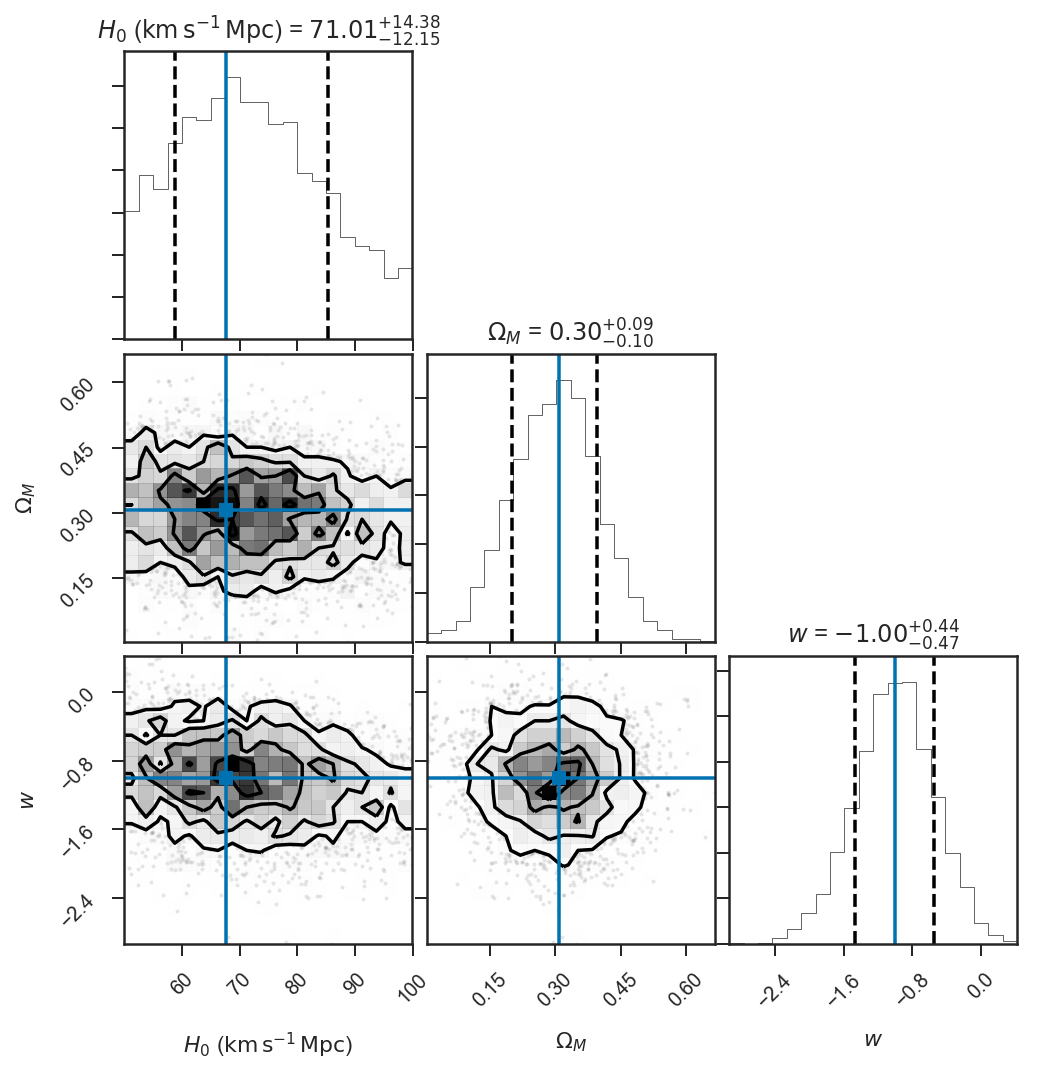

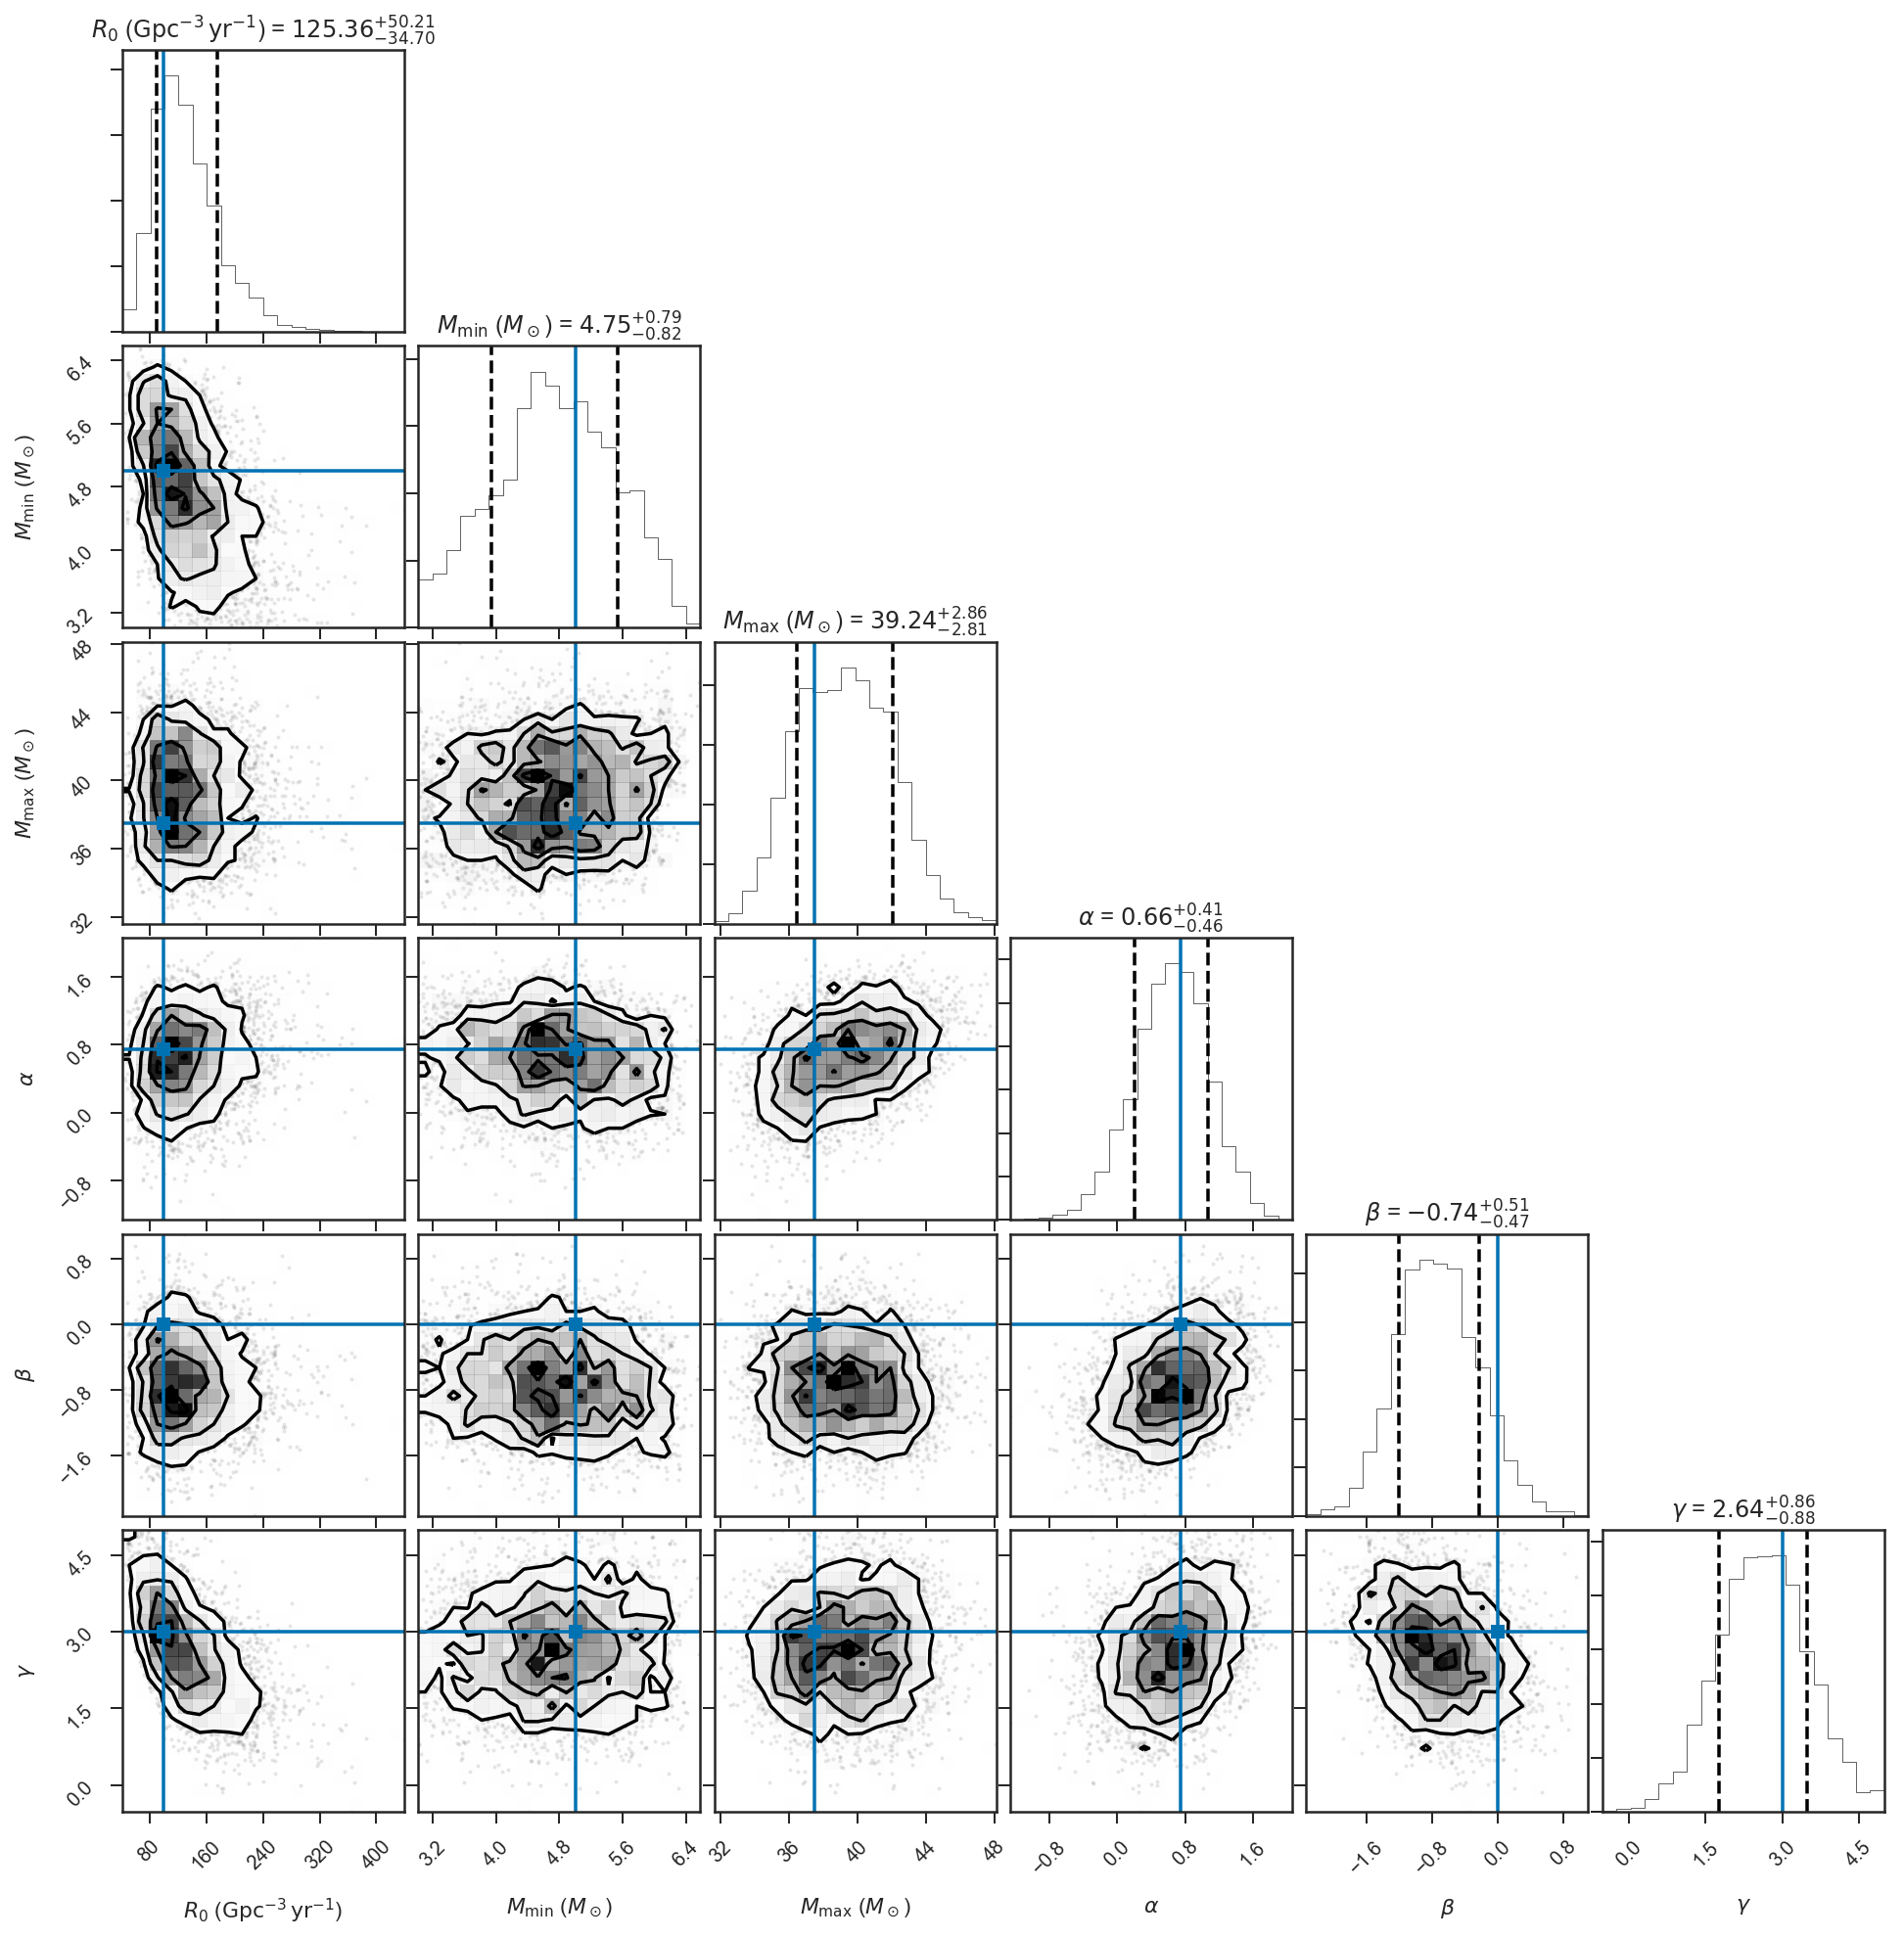

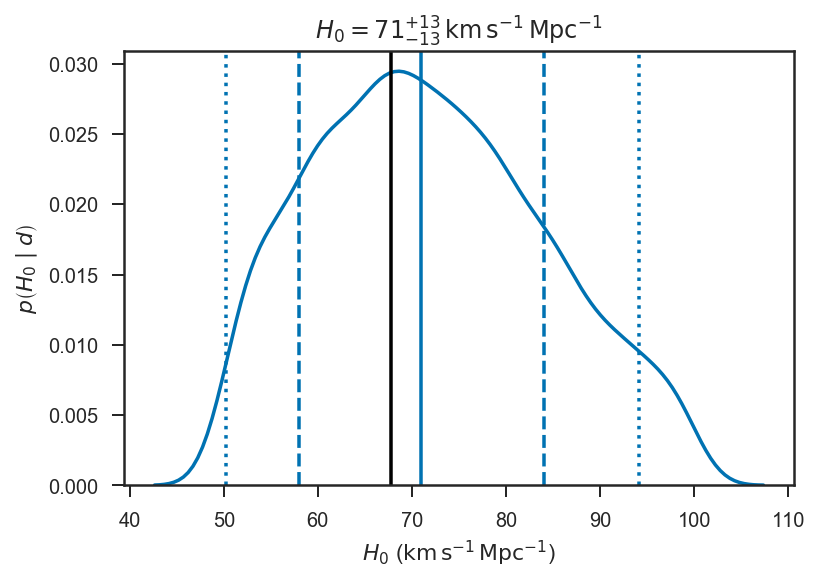

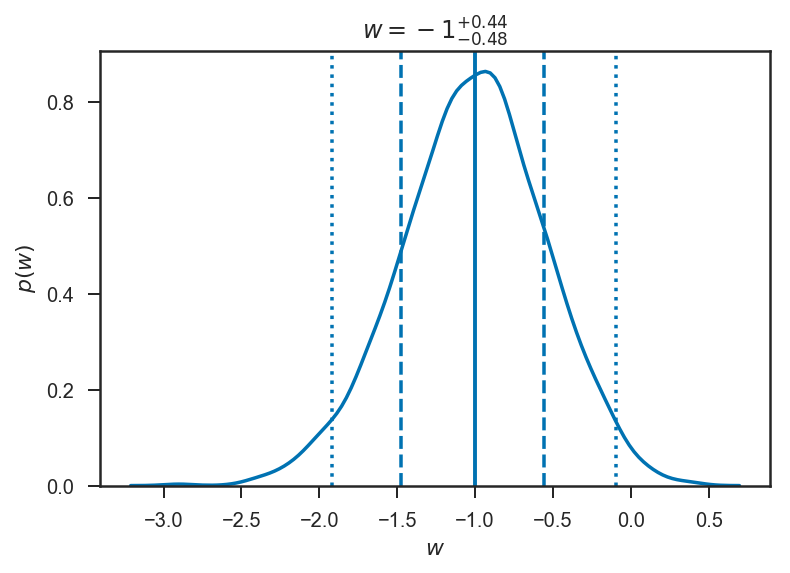

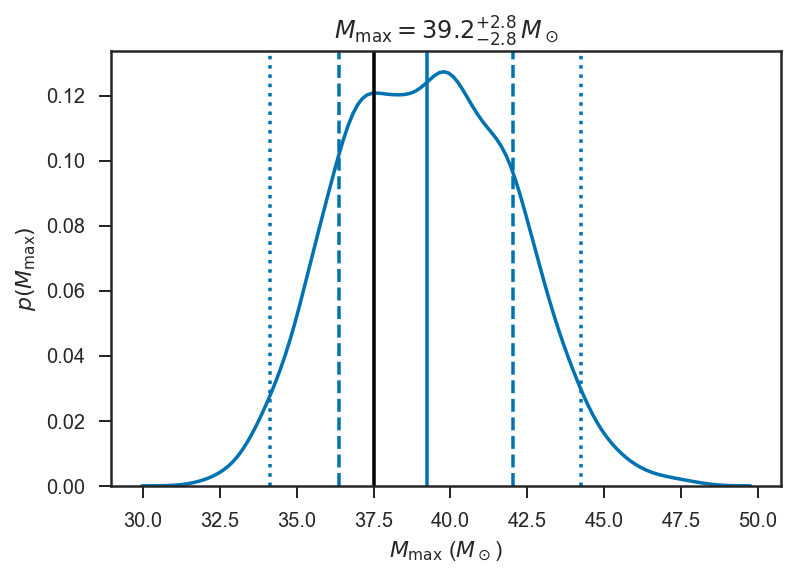

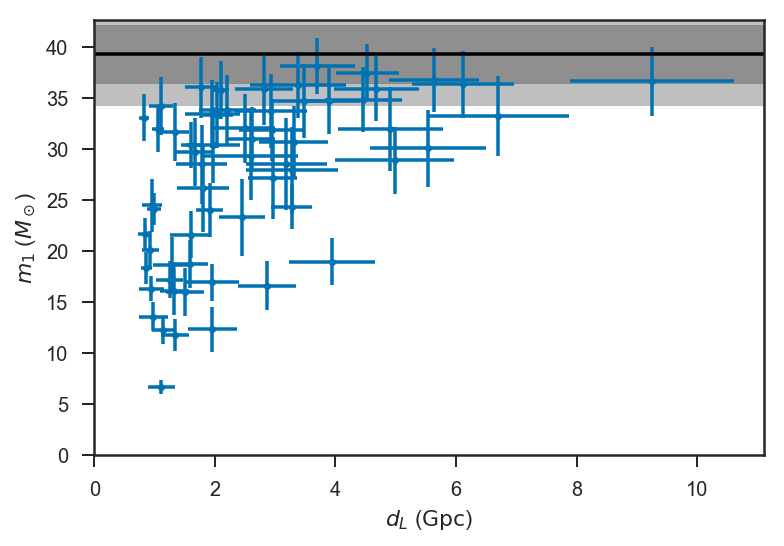

In [106]:
post_process('population_small_free.h5');

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


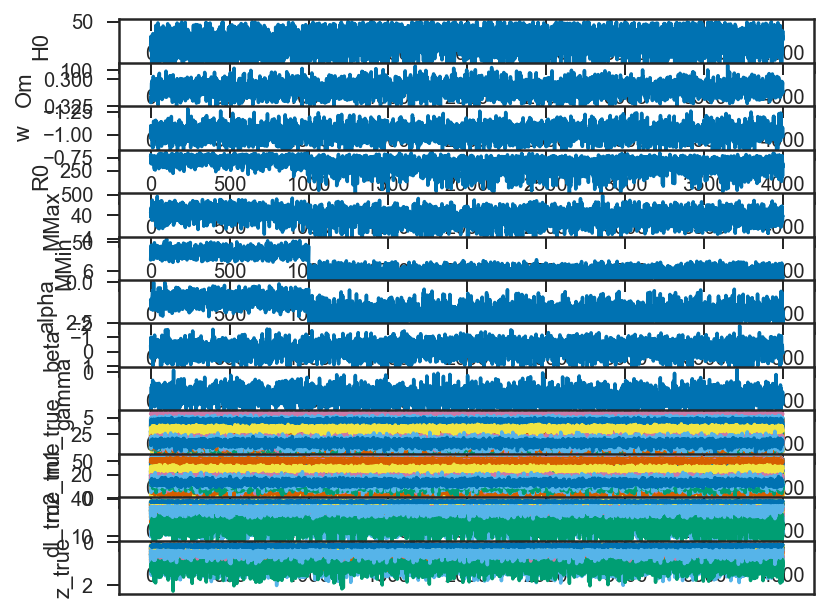

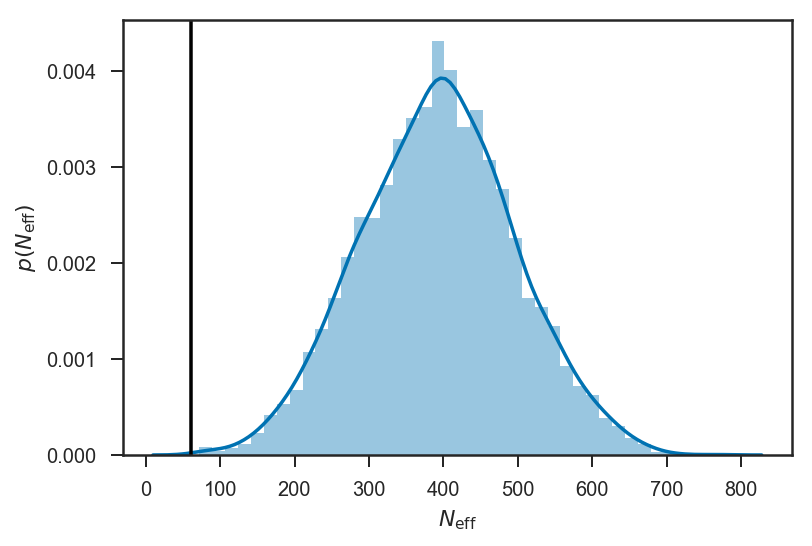

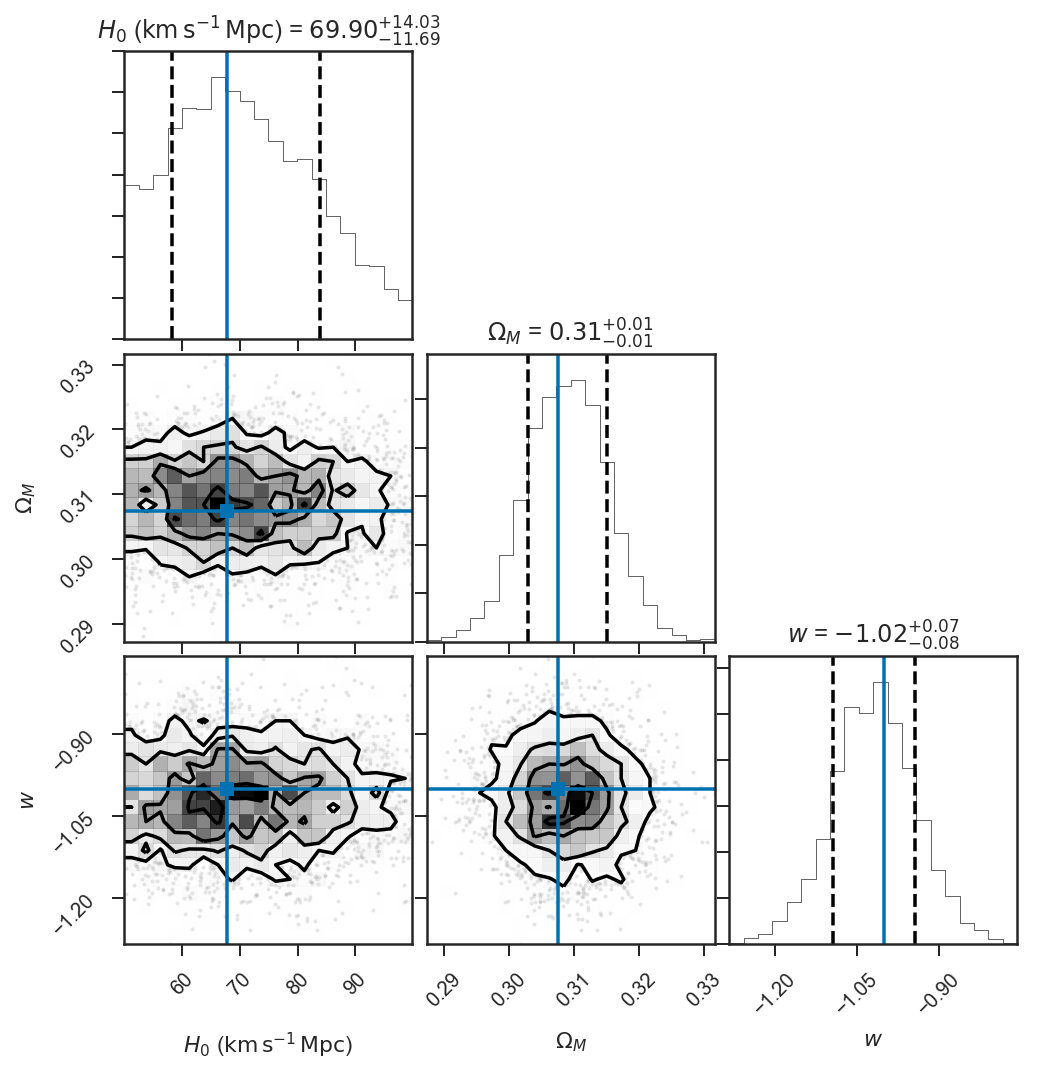

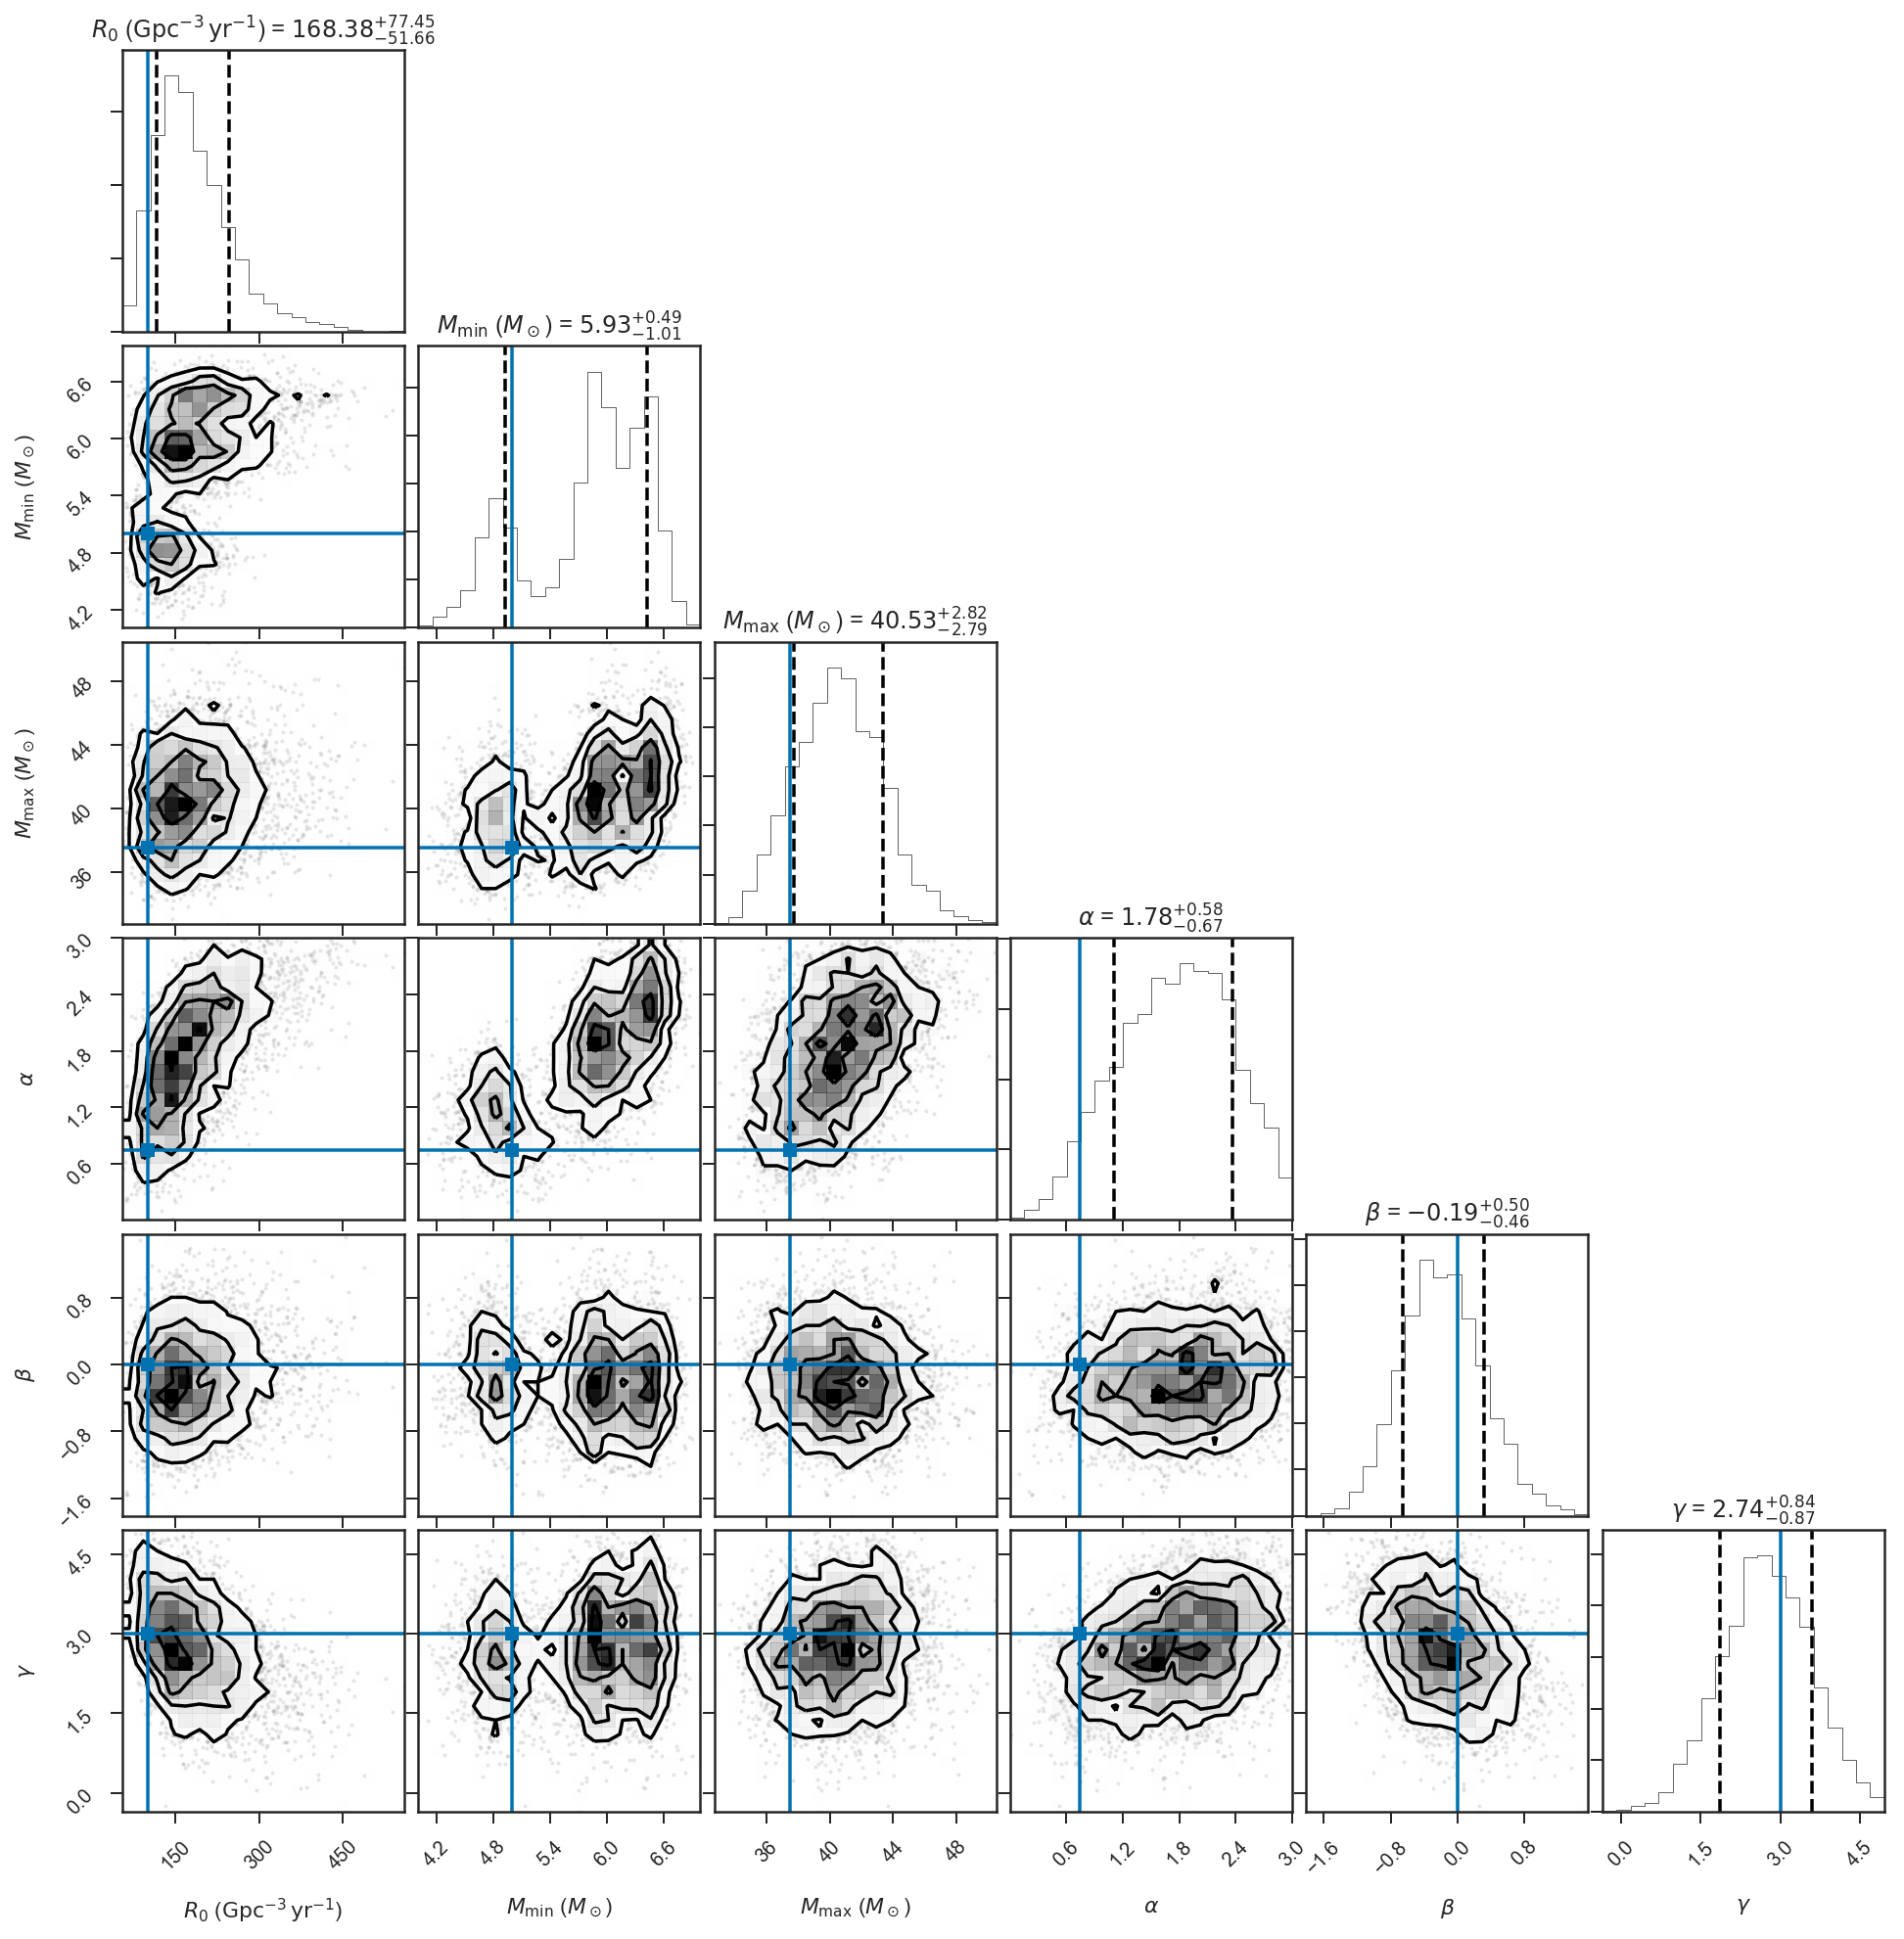

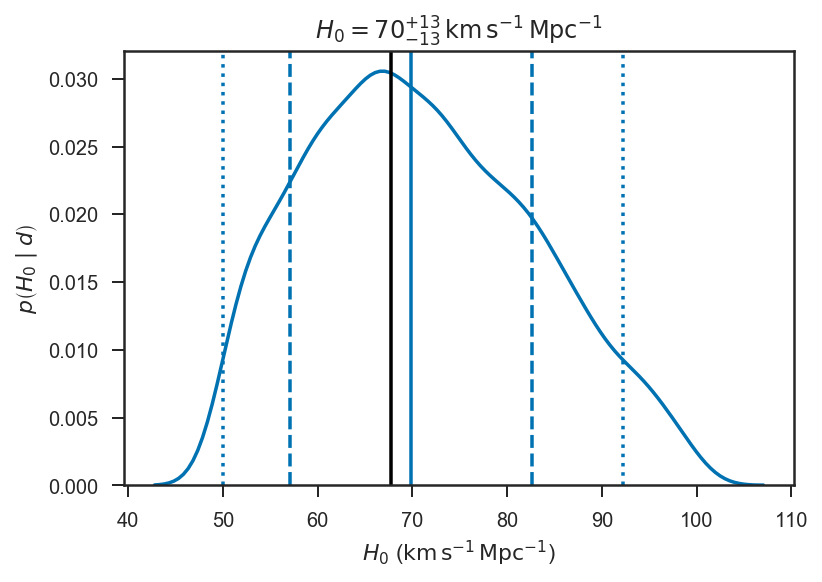

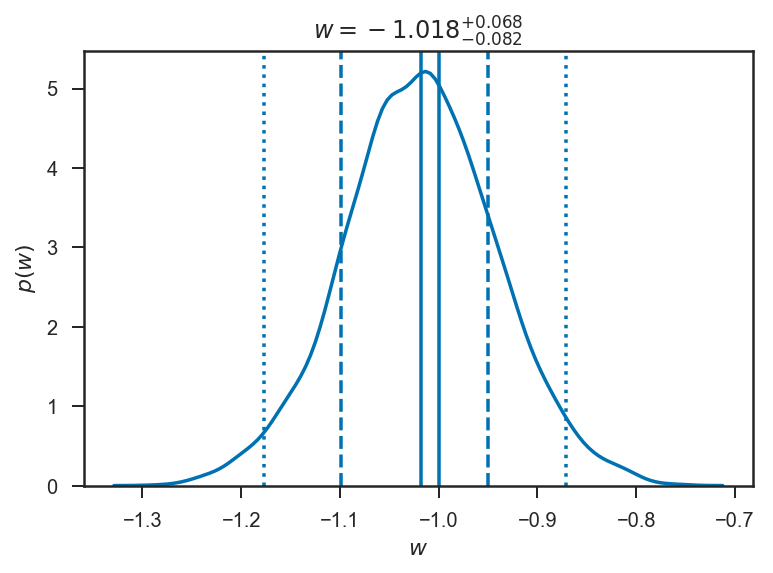

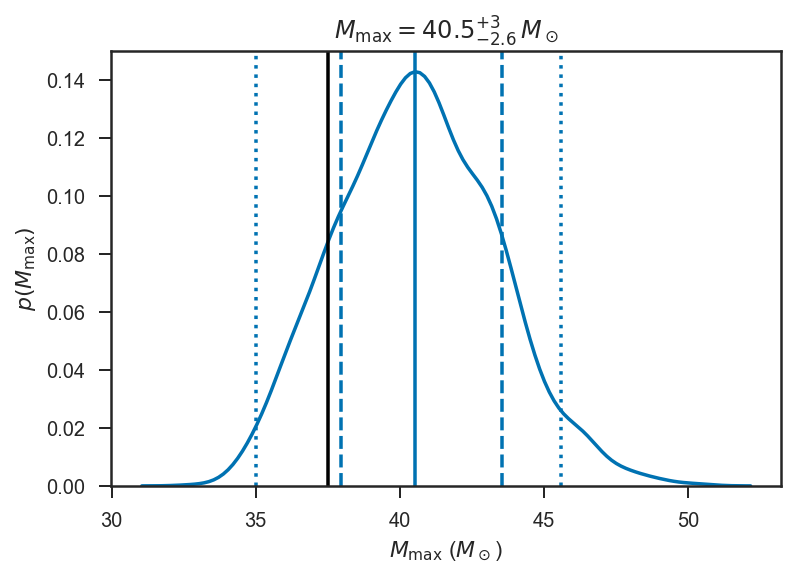

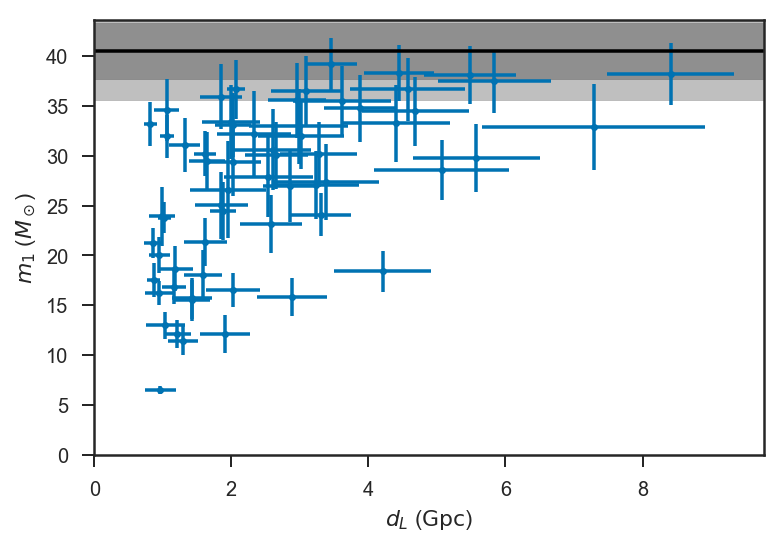

In [108]:
post_process('population_small_Planck_Om_w.h5');

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


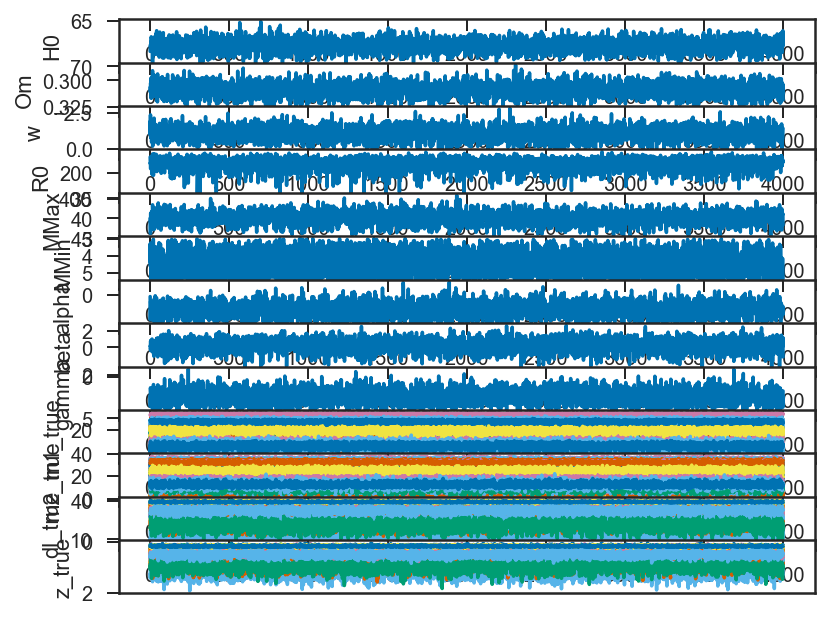

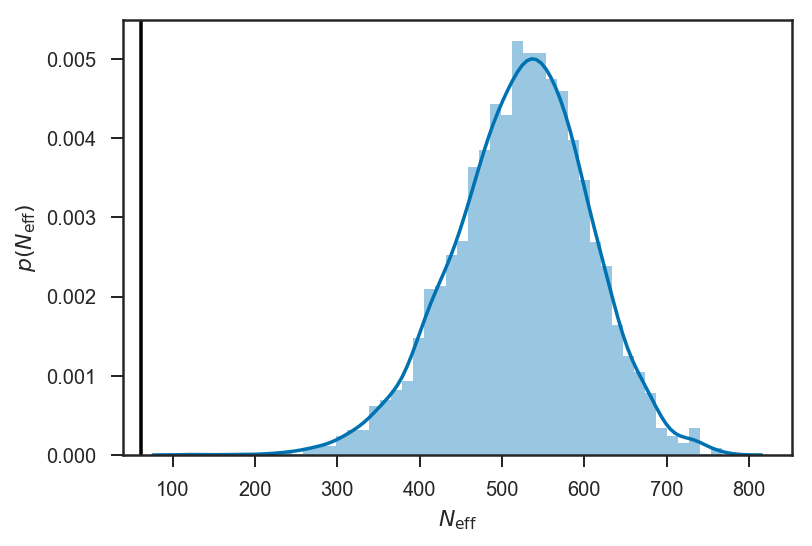

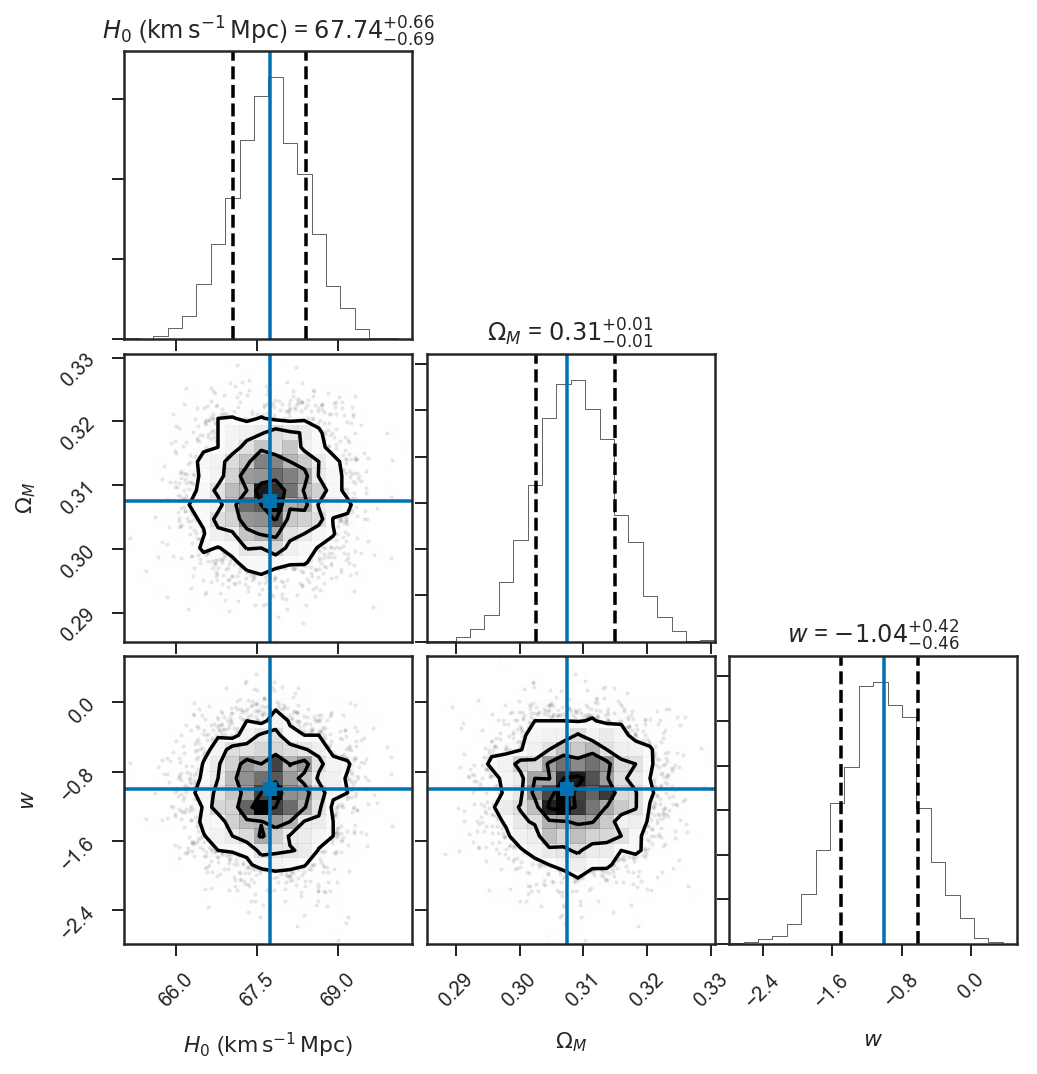

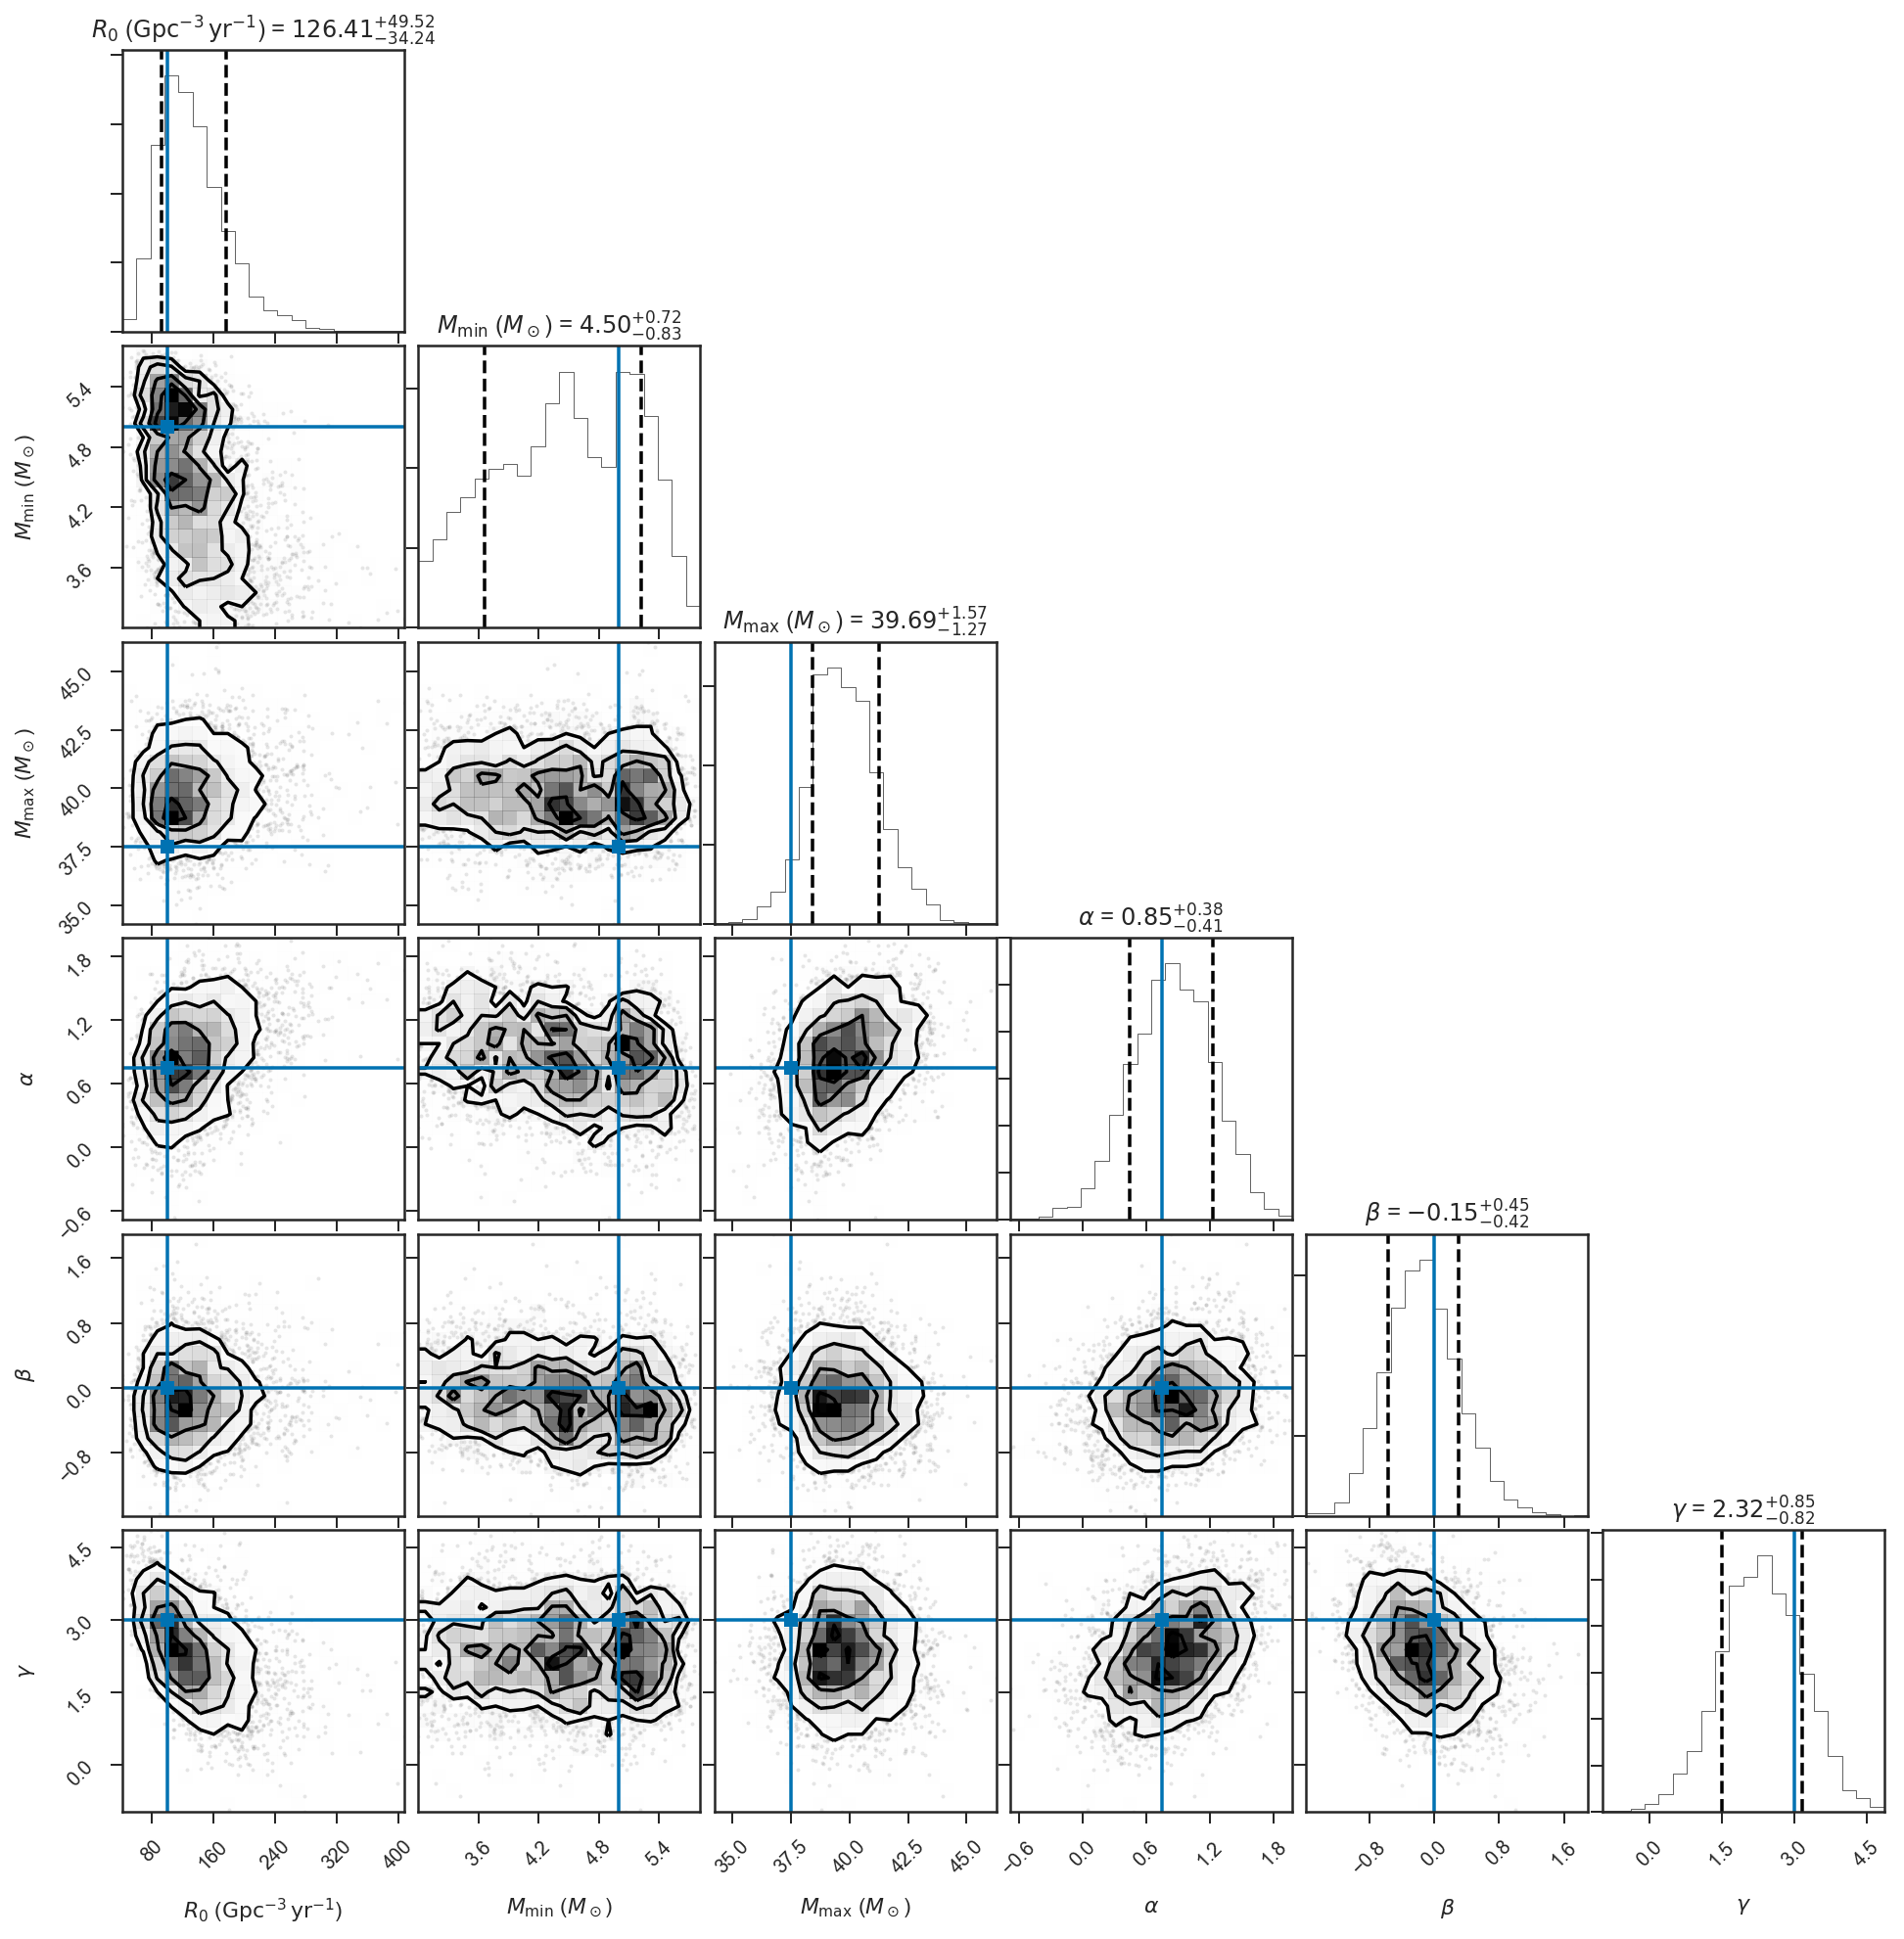

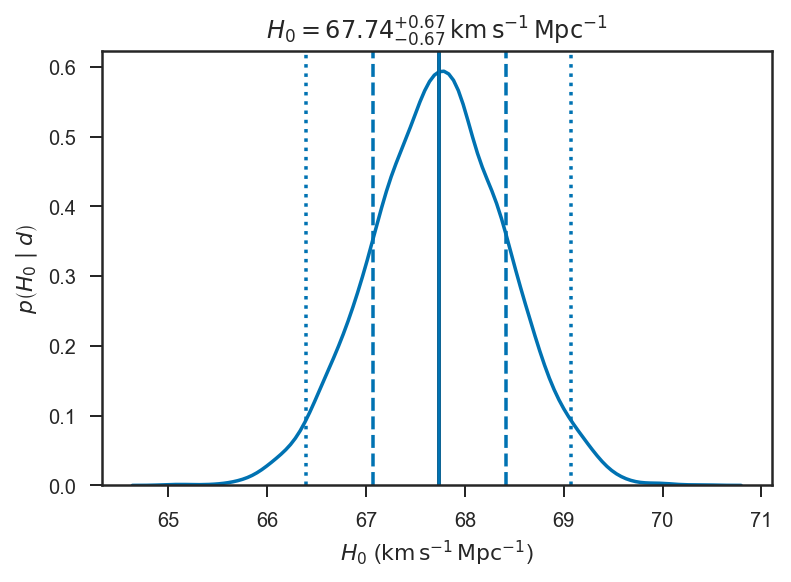

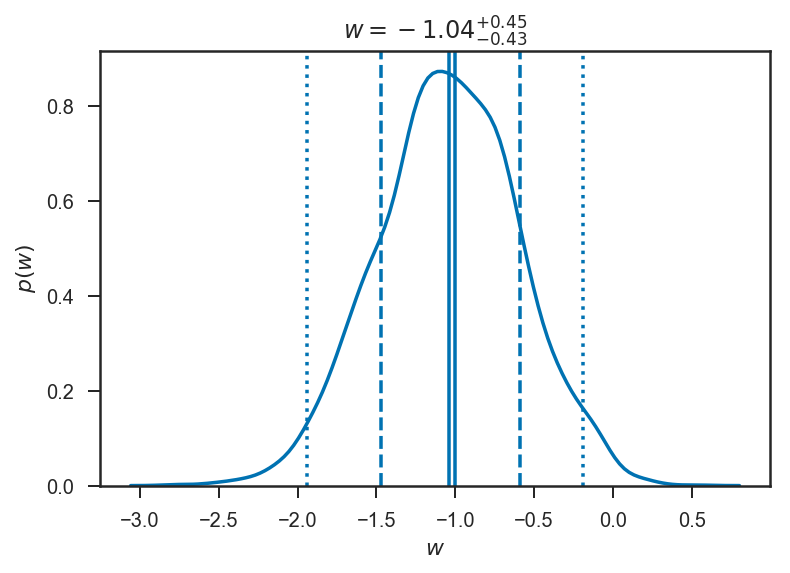

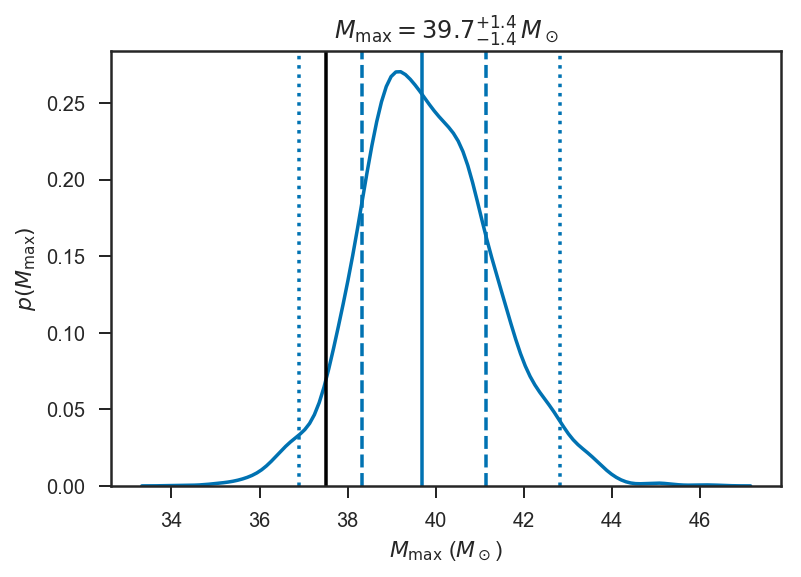

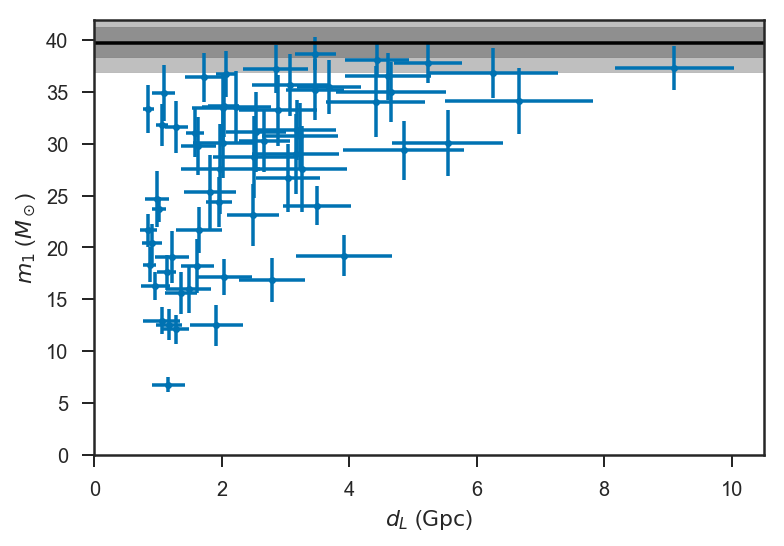

In [103]:
post_process('population_small_H0_Planck_Om.h5');